### MET triple modality autoencoder

In [2]:
import os
import torch
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader
from IPython import display
import seaborn as sns

/home/fahimehb/miniconda3/envs/cplae_met/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cplAE_MET.utils.dataset import MET_exc_inh
from cplAE_MET.utils.load_config import load_config
from cplAE_MET.models.torch_utils import MET_dataset, tonumpy
from cplAE_MET.utils.plots import plot_m, plot_z, plot_z_3d
from cplAE_MET.utils.utils import loadpkl

In [4]:
import optuna
import matplotlib.pyplot as plt
from optuna.visualization import plot_edf
from optuna.visualization import plot_contour
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate

In [5]:
from cplAE_MET.utils.utils import loadpkl
from cplAE_MET.models.bayesian_optimization import set_paths, denovo_clustering_gmm
from cplAE_MET.utils.dataset import MET_exc_inh_v2
from cplAE_MET.models.model_classes import Model_ME_T_v2
from cplAE_MET.models.torch_utils import MET_dataset_v2
from cplAE_MET.models.torch_utils import tonumpy
from cplAE_MET.utils.plots import plot_m, plot_z, plot_z_3d

In [3]:
storage = "sqlite://///home/fahimehb/Local/new_codes/cplAE_MET/data/results/optuna_all_connected_objective_v2_gmm_1000trial_2000epochs/optuna_all_connected_objective_v2_gmm_1000trial_2000epochs.db"

In [4]:
exp_name="optuna_all_connected_objective_v2_gmm_1000trial_2000epochs"
study = optuna.create_study(study_name=exp_name,
                            direction="maximize",
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(),
                            storage=storage,
                            load_if_exists=True)

[I 2023-01-23 09:56:24,336] Using an existing study with name 'optuna_all_connected_objective_v2_gmm_1000trial_2000epochs' instead of creating a new one.


In [5]:
len(study.trials)

5031

In [6]:
study.best_trial

FrozenTrial(number=1471, values=[23.0], datetime_start=datetime.datetime(2023, 1, 21, 9, 19, 35, 348433), datetime_complete=datetime.datetime(2023, 1, 21, 10, 48, 2, 672826), params={'lambda_tune_E_M': 1.8355894073120875, 'lambda_tune_E_ME': 0.4822783235394059, 'lambda_tune_E_T': 0.8246425039836841, 'lambda_tune_ME_E': 1.2753897022936314, 'lambda_tune_ME_M': 0.5333778365020028, 'lambda_tune_ME_T': 3.0754736797784306, 'lambda_tune_M_E': 0.3869665067533954, 'lambda_tune_M_ME': 4.465049450256818, 'lambda_tune_M_T': 4.532209800922877, 'lambda_tune_T_E': 3.86206749674248, 'lambda_tune_T_M': 4.5024330786524525, 'lambda_tune_T_ME': 4.629676075150611}, distributions={'lambda_tune_E_M': FloatDistribution(high=5.0, log=False, low=0.2, step=None), 'lambda_tune_E_ME': FloatDistribution(high=5.0, log=False, low=0.2, step=None), 'lambda_tune_E_T': FloatDistribution(high=5.0, log=False, low=0.2, step=None), 'lambda_tune_ME_E': FloatDistribution(high=5.0, log=False, low=0.2, step=None), 'lambda_tune_M

In [8]:
study.best_params

{'lambda_tune_E_M': 1.8355894073120875,
 'lambda_tune_E_ME': 0.4822783235394059,
 'lambda_tune_E_T': 0.8246425039836841,
 'lambda_tune_ME_E': 1.2753897022936314,
 'lambda_tune_ME_M': 0.5333778365020028,
 'lambda_tune_ME_T': 3.0754736797784306,
 'lambda_tune_M_E': 0.3869665067533954,
 'lambda_tune_M_ME': 4.465049450256818,
 'lambda_tune_M_T': 4.532209800922877,
 'lambda_tune_T_E': 3.86206749674248,
 'lambda_tune_T_M': 4.5024330786524525,
 'lambda_tune_T_ME': 4.629676075150611}

In [25]:
np.min([100,20])

20

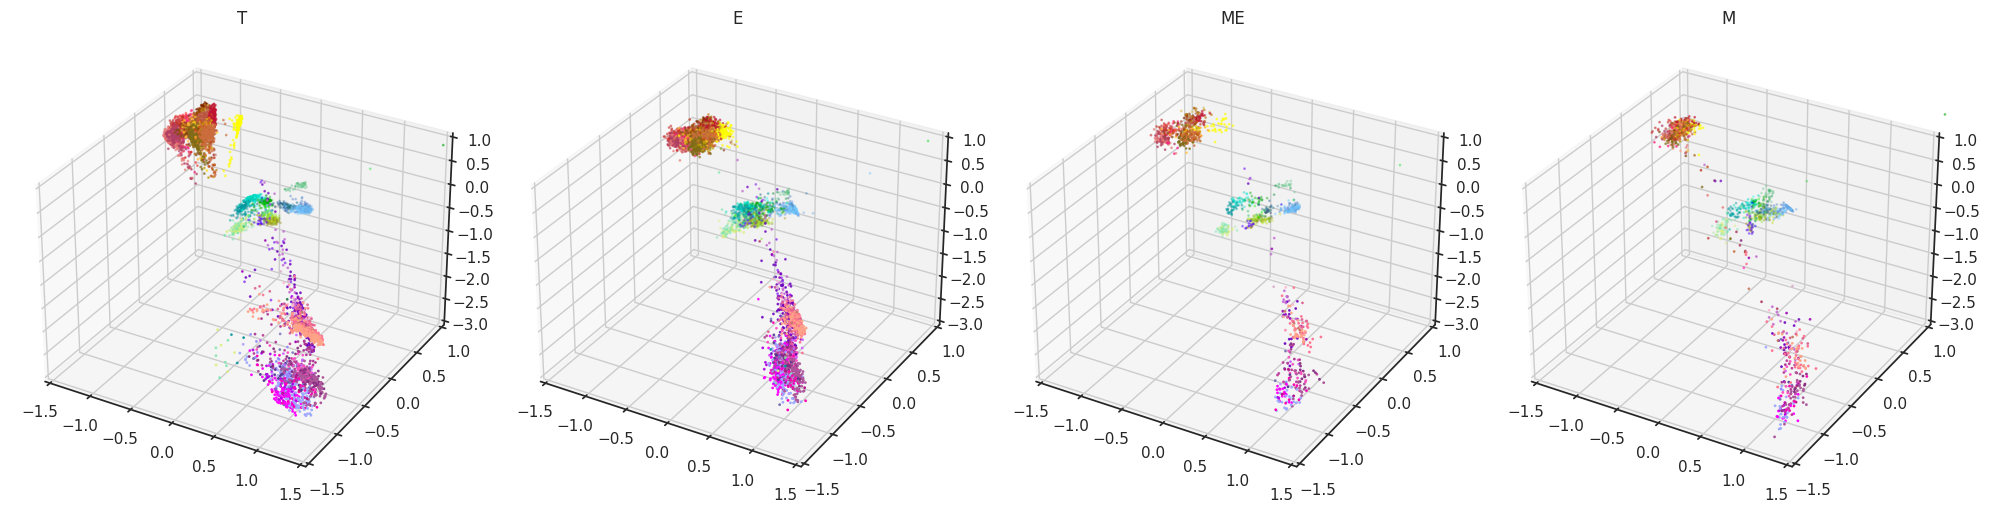

In [30]:
folder ="/home/fahimehb/Local/new_codes/cplAE_MET/data/results/T_ME_all_connected_higher_range_of_lambdas_v0/"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z_3d(output, xlim=(-1.5, 1.5), ylim=(-1.5,1), zlim=(-3,1))

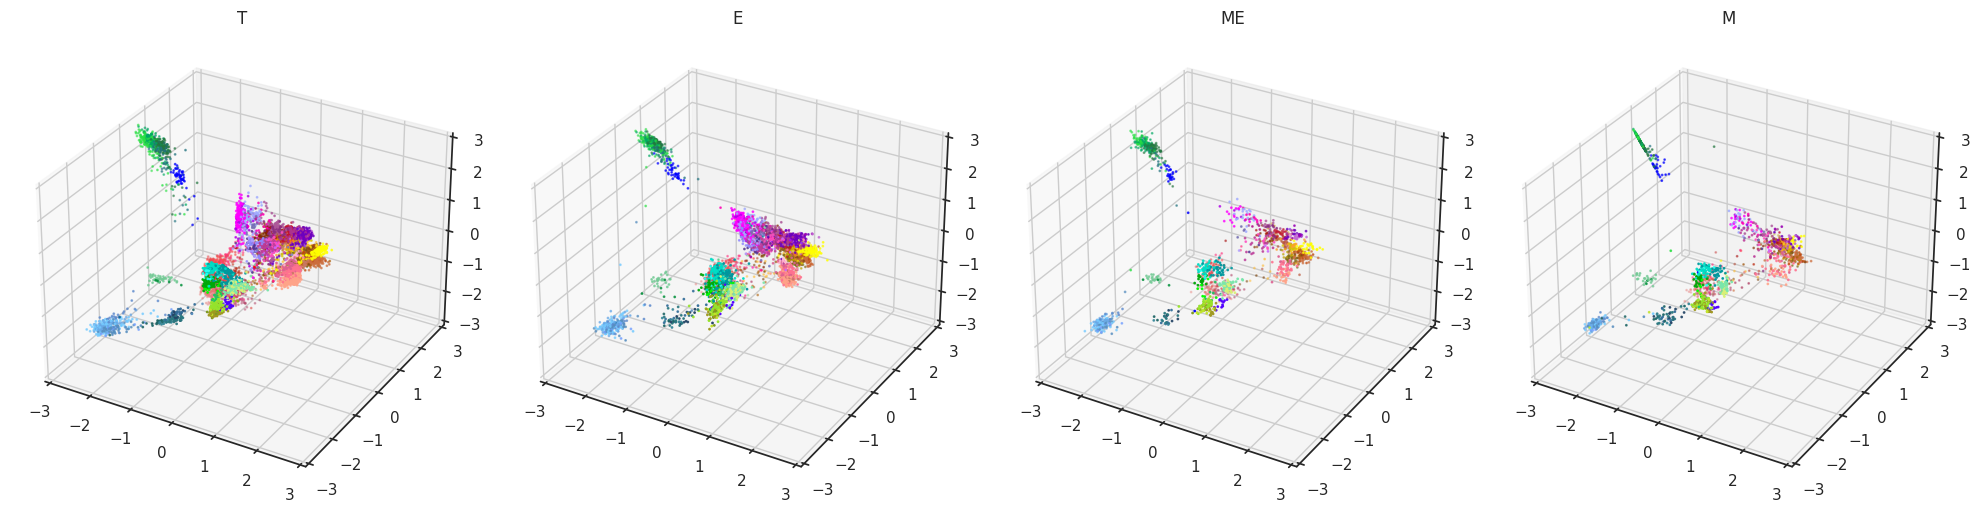

In [11]:
folder ="/home/fahimehb/Local/new_codes/cplAE_MET/data/results/T_ME_all_connected_higher_range_of_lambdas_v6/"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z_3d(output, xlim=(-3, 3), ylim=(-3,3), zlim=(-3,3))

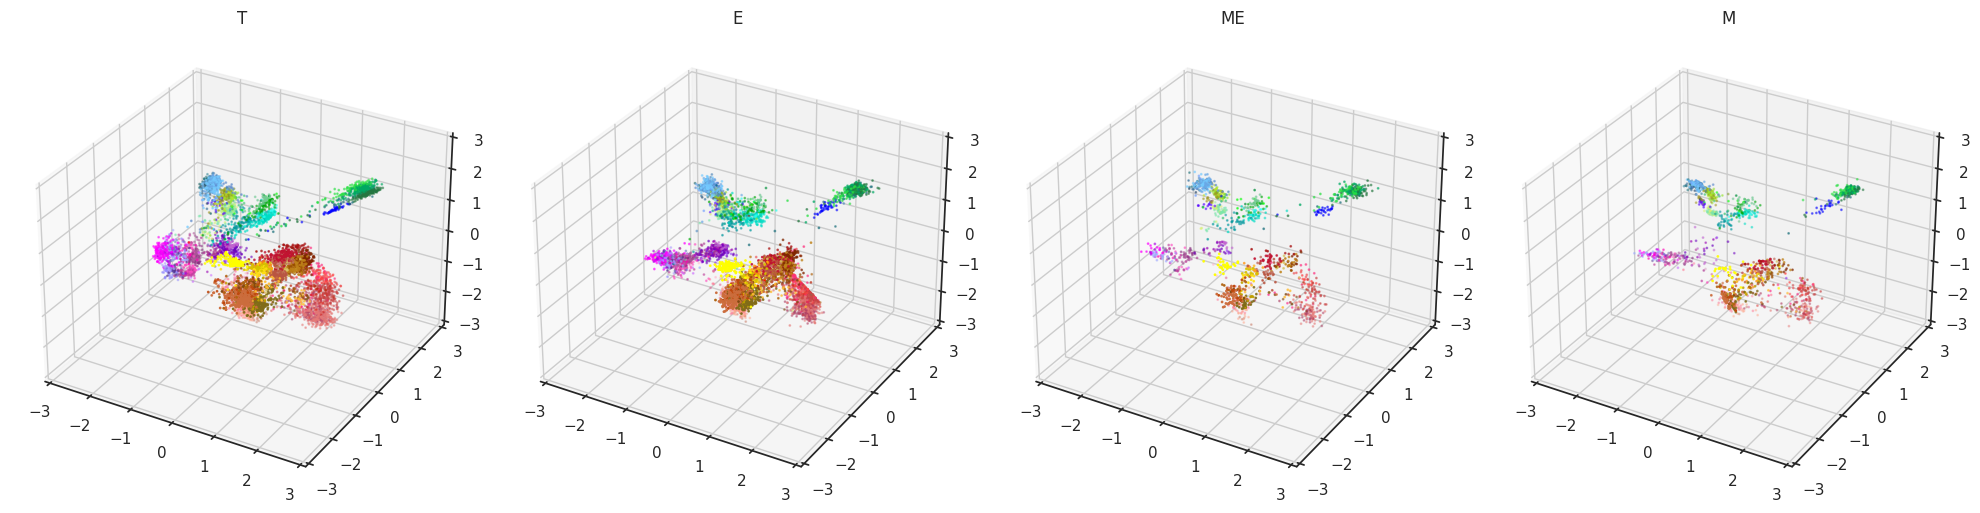

In [21]:
folder ="/home/fahimehb/Local/new_codes/cplAE_MET/data/results/TEM_8643_103MNPCs_26Mfeatures_l3_v0/"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z_3d(output, xlim=(-3, 3), ylim=(-3,3), zlim=(-3,3))

In [8]:
from sklearn.mixture import GaussianMixture

def denovo_clustering_gmm(X, n_components_range=np.arange(1,93), covariance_type="full", random_state=0, n_init=1):

    models = [GaussianMixture(n, 
                              covariance_type=covariance_type,
                              random_state=random_state, 
                              n_init=n_init, 
                              reg_covar=1e-4).fit(X) 
                        for n in n_components_range]
    return models

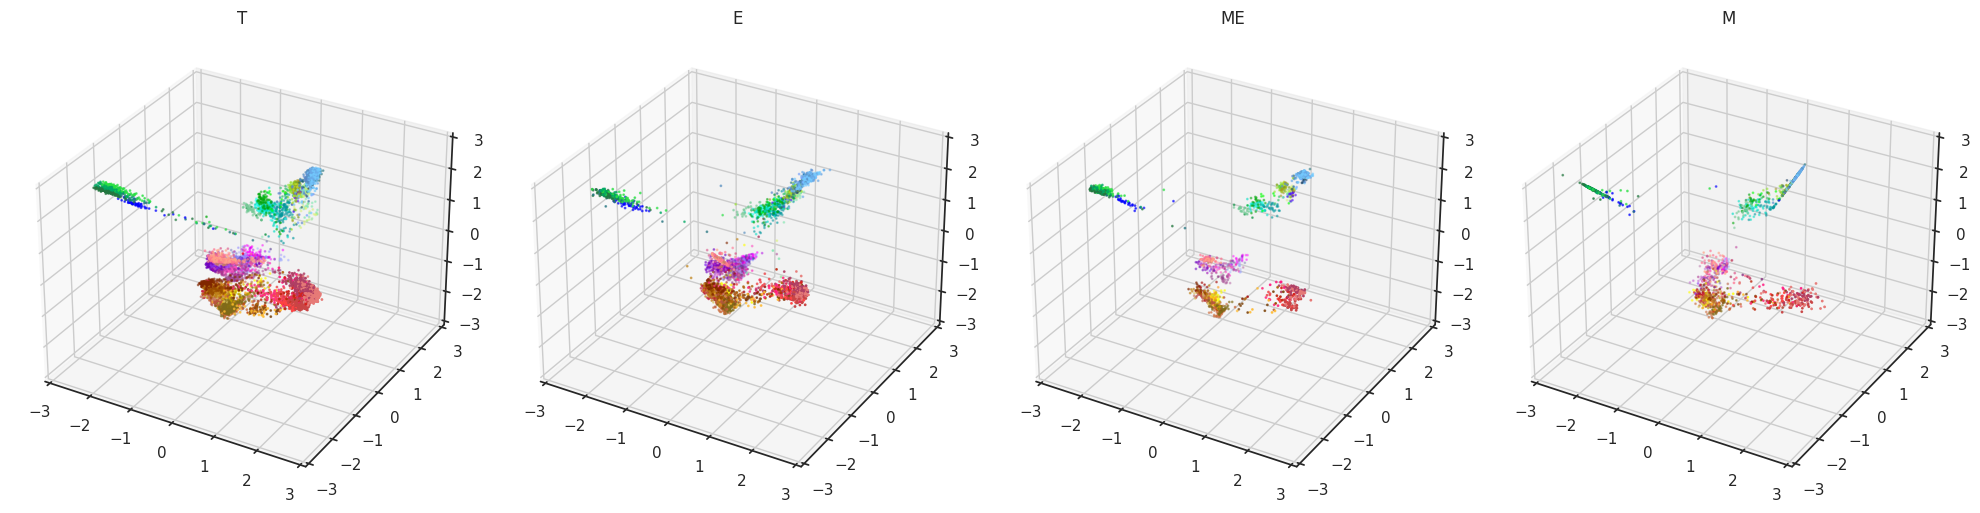

In [9]:
path ="/home/fahimehb/Local/new_codes/cplAE_MET/data/results/optuna_all_connected_objective_v2_gmm_1000trial_2000epochs_range_v3/exit_summary_test.pkl"
output = loadpkl(path)
plot_z_3d(output, xlim=(-3, 3), ylim=(-3,3), zlim=(-3,3))

In [10]:
print("for optuna_all_connected_objective_v2_gmm_1000trial_2000epochs_range_v3")
is_t_1d = output['is_t_1d']
is_m_1d = output['is_m_1d']
is_e_1d = output['is_e_1d']
is_me_1d = np.logical_and(is_m_1d, is_e_1d)
is_met_1d = np.logical_and(is_t_1d, is_me_1d)

gmm_t = denovo_clustering_gmm(output['zt'][is_t_1d], n_init=10)
gmm_me = denovo_clustering_gmm(output['zme_paired'][is_met_1d], n_init=10)

print(np.argmin([m.bic(output['zt'][is_t_1d]) for m in gmm_t]))
print(np.argmin([m.bic(output['zme_paired'][is_met_1d]) for m in gmm_me]))

for optuna_all_connected_objective_v2_gmm_1000trial_2000epochs_range_v3
42
21


In [11]:
print(np.argmin([m.bic(output['zt'][is_t_1d]) for m in gmm_t]))
print(np.argmin([m.bic(output['zme_paired'][is_met_1d]) for m in gmm_me]))

42
21


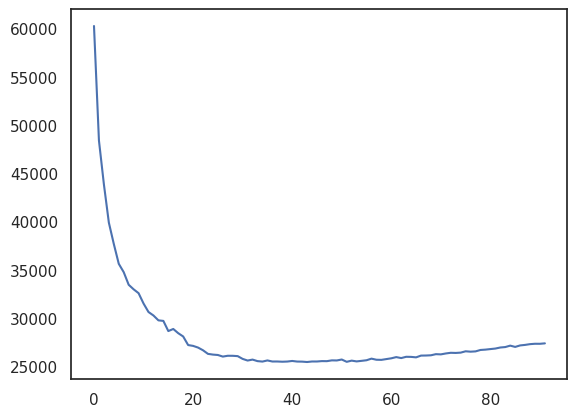

In [24]:
plt.plot([m.bic(output['zt'][is_t_1d]) for m in gmm_t])

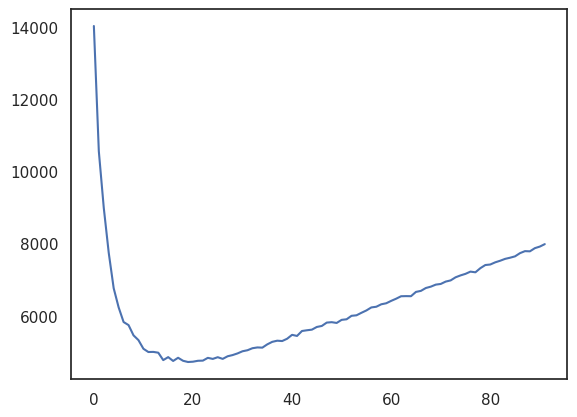

In [25]:
plt.plot([m.bic(output['zme_paired'][is_met_1d]) for m in gmm_me])

In [3]:
def set_paths(config_file=None):
    paths = load_config(config_file=config_file, verbose=False)

    paths['input'] = f'{str(paths["data_dir"])}'
    paths['arbor_density_file'] = f'{paths["input"]}/{str(paths["arbor_density_file"])}'
    paths['arbor_density_PC_file'] = f'{paths["input"]}/{str(paths["arbor_density_PC_file"])}'
    paths['arbor_density_PC_vars_file'] = f'{paths["input"]}/{str(paths["arbor_density_PC_vars_file"])}'

    paths['specimen_ids'] = f'{paths["input"]}/{str(paths["specimen_ids_file"])}'
    paths['gene_file'] = f'{paths["input"]}/{str(paths["gene_file"])}'

    paths['t_anno'] = f'{paths["input"]}/{"anno.feather"}'
    paths['t_data'] = f'{paths["input"]}/{"data.feather"}'
    paths['t_data_output'] = f'{paths["input"]}/{str(paths["t_data_output_file"])}'
    paths['t_anno_output'] = f'{paths["input"]}/{str(paths["t_anno_output_file"])}'
    paths['gene_id_output'] = f'{paths["input"]}/{str(paths["gene_id_output_file"])}'

    paths['m_data_folder'] = f'{paths["input"]}/{str(paths["m_data_folder"])}'
    paths['m_anno'] = f'{paths["m_data_folder"]}/{str(paths["m_anno"])}'
    paths['hist2d_120x4'] = f'{paths["m_data_folder"]}/{str(paths["hist2d_120x4_folder"])}'
    paths['E_timeseries'] = f'{paths["input"]}/{str(paths["E_timeseries_file"])}'
    paths['ipfx_features'] = f'{paths["input"]}/{str(paths["ipfx_features_file"])}'
    paths['e_output'] = f'{paths["input"]}/{str(paths["e_output_file"])}'
    paths['met_output'] = f'{paths["input"]}/{str(paths["met_output_file"])}'
    return paths

In [4]:
dir_pth = set_paths("config_preproc.toml")

KeyError: 'arbor_density_PC_file'

In [ ]:
aspiny_me = pd.read_csv("/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Olga/morphology/arbor_density_ae/ME_cells/aspiny203.csv")['specimen_id'].to_list()
spiny_me = pd.read_csv("/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Olga/morphology/arbor_density_ae/ME_cells/spiny244.csv")['specimen_id'].to_list()
e_only_me_cells = pd.read_csv("/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Patchseq-Exc/dat/ephys_qc_passed_ME_Eonly_specimen_ids_12Dec22.txt", header=None)[0].to_list()
original_me_cells = aspiny_me + spiny_me + e_only_me_cells
original_me_cells = [str(i) for i in original_me_cells]
print("total_number of original me cells:", len(original_me_cells))

spiny_fmost_cells = pd.read_csv("/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Olga/morphology/arbor_density_ae/full_morphology/spiny141.csv")['specimen_id'].to_list()
print("total_number of fmost  cells:", len(spiny_fmost_cells))

t_anno = feather.read_dataframe(dir_pth['t_anno'])
locked_sids = pd.read_csv(dir_pth['specimen_ids'])['specimen_id'].to_list()
patchseq_cells = [i for i in locked_sids if i not in spiny_fmost_cells + original_me_cells]
print("total_number of patchseq cells:", len(patchseq_cells))
print("In total we have this number of cells: ", len(patchseq_cells) + len(spiny_fmost_cells) + len(original_me_cells))

total_number of original me cells: 1932
total_number of fmost  cells: 141
total_number of patchseq cells: 6570
In total we have this number of cells:  8643


In [5]:
# read input mat file 
# paths = load_config(config_file="config.toml", verbose=False)
# dat = MET_exc_inh.from_file(paths['MET_data'])
# dataset = MET_dataset(dat, device='cpu')
# dataloader = DataLoader(dataset, batch_size=dataset.xt.shape[0], shuffle=False, drop_last=False)
# for _, data in enumerate(iter(dataloader)):
#     print ("done!")

# sids = np.array([i.rstrip() for i in dat.specimen_id])

# is_t_1d = tonumpy(data['is_t_1d'])
# is_e_1d = tonumpy(data['is_e_1d'])
# is_m_1d = tonumpy(data['is_m_1d'])
# is_me_1d = np.logical_and(is_m_1d, is_e_1d)
# is_mt_1d = np.logical_and(is_m_1d, is_t_1d)
# is_te_1d = np.logical_and(is_t_1d, is_e_1d)
# is_met_1d = np.logical_and(is_me_1d, is_t_1d)
# is_me_only_1d = np.logical_and(is_me_1d, ~is_t_1d)
# is_m_only_1d = np.logical_and(is_m_1d, np.logical_and(~is_t_1d, ~is_e_1d))
# is_e_only_1d = np.logical_and(is_e_1d, np.logical_and(~is_t_1d, ~is_m_1d))
# is_t_only_1d = np.logical_and(is_t_1d, np.logical_and(~is_m_1d, ~is_e_1d))

In the patchseq data, all the cells with PoorQ quality, should not have t data. But we are going to use their othe modalities if available. Lets check that:

In [ ]:
t_anno = feather.read_dataframe(dir_pth['t_anno'])
Counter(t_anno[t_anno['spec_id_label'].isin(patchseq_cells)]['Tree_call_label'])

Counter({'Core': 3832, 'I1': 1273, 'PoorQ': 60, 'I2': 1260, 'I3': 145})

In [ ]:
PoorQ_sids = t_anno[(t_anno['spec_id_label'].isin(patchseq_cells)) & (t_anno['Tree_call_label']=="PoorQ")]['spec_id_label'].to_list()

Do these cells have e data?

In [ ]:
len([i for i in PoorQ_sids if i in sids[is_e_1d]])

58

Do these poorQ cells have m data?

In [ ]:
len([i for i in PoorQ_sids if i in sids[is_m_1d]])

60

### Patchseq cells overview

In [ ]:
#patchseq details
patchseq_cells_1d = np.array([True if i.rstrip() in patchseq_cells else False for i in dat.specimen_id])

patchseq_t_only = np.logical_and(is_t_1d, np.logical_and(~is_m_1d, ~is_e_1d))
patchseq_te_only = np.logical_and(~is_m_1d, np.logical_and(is_t_1d, is_e_1d))
patchseq_mt_only = np.logical_and(~is_e_1d, np.logical_and(is_t_1d, is_m_1d))
patchseq_met_only = np.logical_and(is_e_1d, np.logical_and(is_t_1d, is_m_1d))

patchseq_m_or_e = np.logical_and(patchseq_cells_1d, ~is_t_1d)
patchseq_m_only = np.logical_and(~is_e_1d, np.logical_and(patchseq_m_or_e, is_m_1d))
patchseq_e_only = np.logical_and(~is_m_1d, np.logical_and(patchseq_m_or_e, is_e_1d))
patchseq_me_only = np.logical_and(~is_t_1d, np.logical_and(patchseq_m_or_e, is_me_1d))


print(patchseq_t_only.sum(), patchseq_te_only.sum(), patchseq_mt_only.sum(), patchseq_met_only.sum(), patchseq_m_only.sum(), patchseq_e_only.sum(), patchseq_me_only.sum())
print(patchseq_t_only.sum()+ patchseq_te_only.sum()+ patchseq_mt_only.sum()+ patchseq_met_only.sum()+ patchseq_m_only.sum()+ patchseq_e_only.sum()+ patchseq_me_only.sum())

554 4441 102 1413 2 0 58
6570


How about the me cells? lets see how many havet, how many have m only, how may have m&e and how many have e only!

none of them should have t data available

### ME cells overview

In [ ]:
me_cells_t_only = np.array([i for i in original_me_cells if i in sids[is_t_1d]])
me_cells_me = np.array([i for i in original_me_cells if i in sids[is_me_1d]])
me_cells_m_only = np.array([i for i in original_me_cells if i in sids[is_m_only_1d]])
me_cells_e_only = np.array([i for i in original_me_cells if i in sids[is_e_only_1d]])

print(len(me_cells_t_only), len(me_cells_me), len(me_cells_m_only), len(me_cells_e_only))
print(len(me_cells_t_only)+ len(me_cells_me)+ len(me_cells_m_only)+ len(me_cells_e_only))


0 444 3 1485
1932


### fMOST cells overview

In [ ]:
fmost_cells_t = np.array([i for i in spiny_fmost_cells if i in sids[is_t_1d]])
fmost_cells_e = np.array([i for i in spiny_fmost_cells if i in sids[is_me_1d]])
fmost_cells_m = np.array([i for i in spiny_fmost_cells if i in sids[is_m_only_1d]])

print(len(fmost_cells_t), len(fmost_cells_e), len(fmost_cells_m))
print(len(fmost_cells_t)+ len(fmost_cells_e)+ len(fmost_cells_m))

0 0 141
141


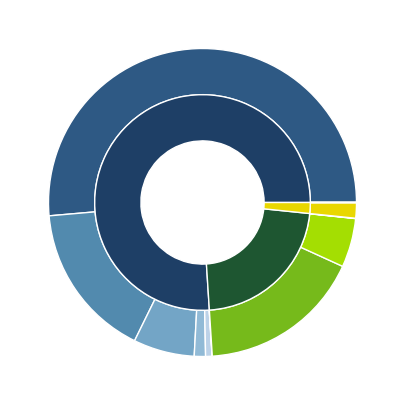

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

size = 0.3
vals = np.array([[patchseq_te_only.sum(), patchseq_met_only.sum(), patchseq_t_only.sum(), patchseq_mt_only.sum(), patchseq_me_only.sum(), patchseq_m_only.sum()],
                 [len(me_cells_e_only), len(me_cells_me), len(me_cells_m_only) ,0, 0, 0],
                 [len(fmost_cells_m),0,0,0, 0, 0]])

cmap = plt.colormaps["tab20c"]
outer_colors = ["#1E3F66", "#1E5631", "#e9d700"]
inner_colors = ["#2E5984","#528AAE",  "#73A5C6", "#91BAD6", "#BCD2E8", "#1E3F66","#76BA1B", "#A4DE02", "#1E5631", "#FFDAB9","#e9d700","#e9d700", "#e9d700", "#e9d700","#e9d700","#e9d700"]

labels_inner = ["T & E", "M & E & T", "T", "M & T", "M & E", "M", "E", "M & E", "M", "", "", "", "M", "M"]
labels_outer = ["Patchseq cells", "ME cells", "Fmost cells"]

ax.pie(vals.flatten(), radius=1, colors=inner_colors, 
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.sum(axis=1), radius=1-size, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

# plt.title("Dataset overviews")

plt.show()

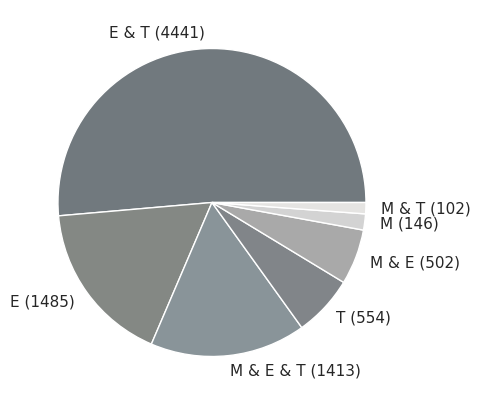

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

TE_cells = patchseq_te_only.sum()
E_cells = len(me_cells_e_only)
MET_cells = patchseq_met_only.sum()
T_cells = patchseq_t_only.sum()
ME_cells =patchseq_me_only.sum()+ len(me_cells_me)
M_cells = patchseq_m_only.sum() + len(me_cells_m_only) + len(fmost_cells_m)
MT_cells = patchseq_mt_only.sum()

y = np.array([TE_cells, E_cells, MET_cells, T_cells, ME_cells, M_cells, MT_cells])
colors= ["#71797E", "#848884", "#899499", "#818589", "#A9A9A9", "#D3D3D3", "#E5E4E2"]
labels = ["E & T (%i)" % TE_cells, 
          "E (%i)" % E_cells, 
          "M & E & T (%i)" % MET_cells,
          "T (%i)" %(T_cells), 
          "M & E (%i)" %(ME_cells) ,
          "M (%i)" %(M_cells), 
          "M & T (%i)" %(MT_cells)]
plt.pie(y, colors=colors, labels=labels)
plt.show()

### Data overview

We have added ME cells and the full morphology cells to the previous dataset. The cells with the full morphology just have the M data available and no E or T data is available for them.

In [ ]:
is_t_1d = tonumpy(data['is_t_1d'])
is_e_1d = tonumpy(data['is_e_1d'])
is_m_1d = tonumpy(data['is_m_1d'])
is_me_1d = np.logical_and(is_m_1d, is_e_1d)
is_mt_1d = np.logical_and(is_m_1d, is_t_1d)
is_te_1d = np.logical_and(is_t_1d, is_e_1d)
is_met_1d = np.logical_and(is_me_1d, is_t_1d)
m_only_1d = np.logical_and(is_m_1d, np.logical_and(~is_t_1d, ~is_e_1d))
e_only_1d = np.logical_and(is_e_1d, np.logical_and(~is_t_1d, ~is_m_1d))
t_only_1d = np.logical_and(is_t_1d, np.logical_and(~is_m_1d, ~is_e_1d))


print("Total number of all the cells: ", data['xt'].shape[0])
print("Total number of cells with T data: ", is_t_1d.sum())
print("Total number of cells with E data: ", is_e_1d.sum())
print("Total number of cells with M data: ", is_m_1d.sum())
print("Total number of cells with M & E data: ", is_me_1d.sum())
print("Total number of cells with M & T data: ", is_mt_1d.sum())
print("Total number of cells with T & E data: ", is_te_1d.sum())
print("Total number of cells with M & E & T data: ", is_met_1d.sum())
print("Total number of cells with T data and no M/E: ", t_only_1d.sum())
print("Total number of cells with E data and no M/T: ", e_only_1d.sum())
print("Total number of cells with M data and no E/T: ", m_only_1d.sum())


Total number of all the cells:  8643
Total number of cells with T data:  6510
Total number of cells with E data:  7841
Total number of cells with M data:  2163
Total number of cells with M & E data:  1915
Total number of cells with M & T data:  1515
Total number of cells with T & E data:  5854
Total number of cells with M & E & T data:  1413
Total number of cells with T data and no M/E:  554
Total number of cells with E data and no M/T:  1485
Total number of cells with M data and no E/T:  146


In [ ]:
# Input features
print("Number of T features: ", data['xt'].shape[1])
print("Number of E features: ", data['xe'].shape[1])
print("Number of M features: ", data['xm'].shape)

Number of T features:  1252
Number of E features:  83
Number of M features:  1


In [ ]:
data['xm'].shape

torch.Size([8643, 1, 240, 4, 4])

Text(0.5, 0, 'xm')

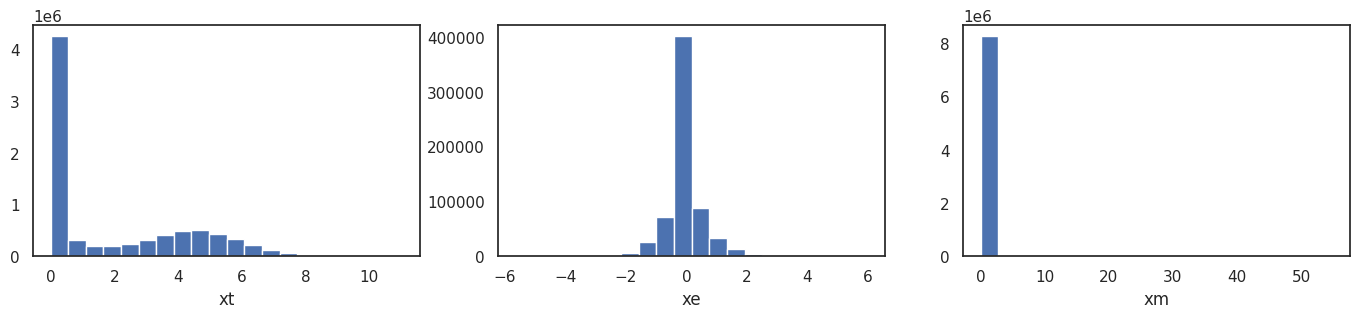

In [ ]:
# input data histograms
fig, axs = plt.subplots(1,3, figsize=(17, 3))
_ = axs[0].hist(tonumpy(data['xt'][data['valid_xt']]), bins=20)
_ = axs[1].hist(tonumpy(data['xe'][data['valid_xe']]), bins=20)
_ = axs[2].hist(tonumpy(data['xm'][data['valid_xm']]), bins=20)
axs[0].set_xlabel("xt")
axs[1].set_xlabel("xe")
axs[2].set_xlabel("xm")

### Triple modality coupled autoencoder model architecture 

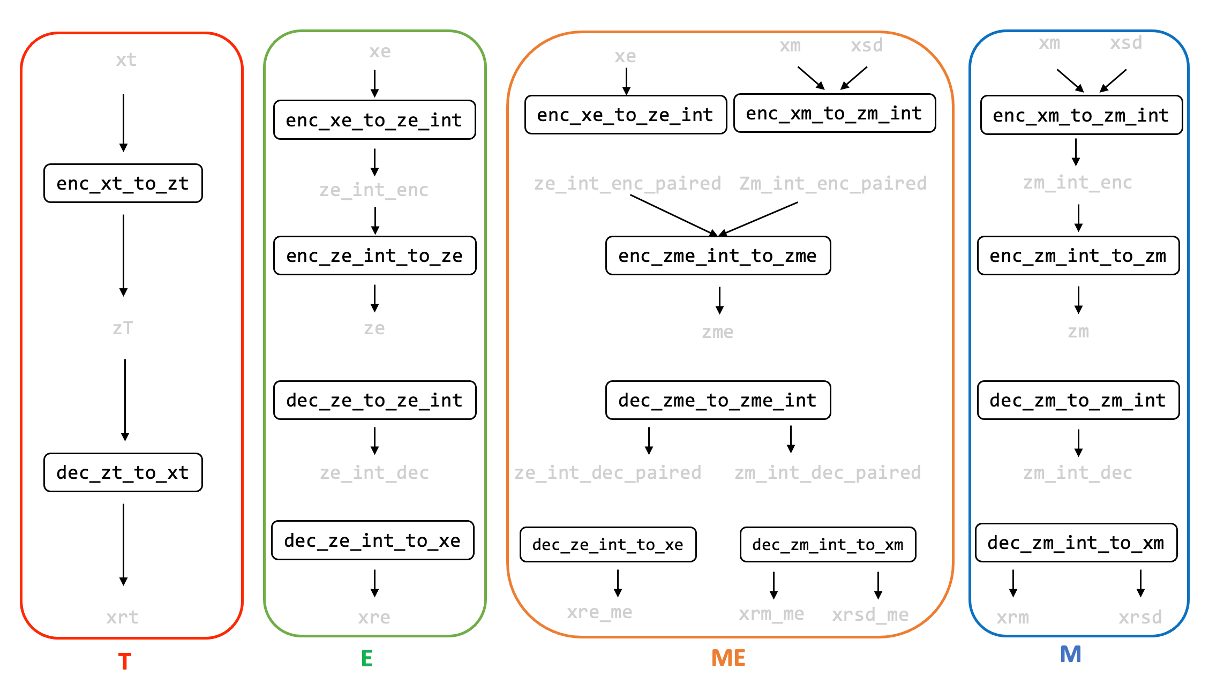

In [ ]:
display.Image("/home/fahimehb/Local/data/proc/MET.png")

### M, E, T and ME separate autoencoders 

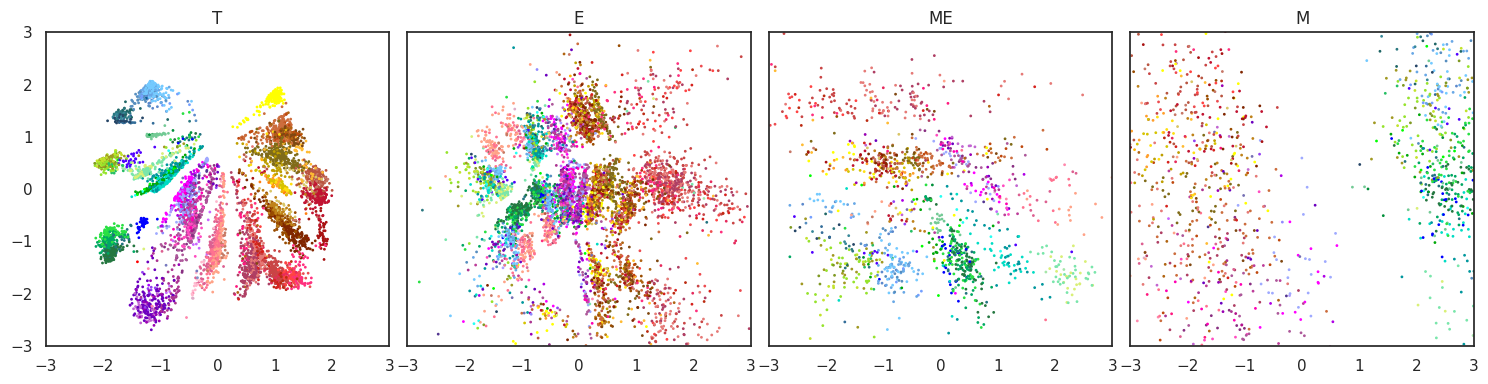

In [7]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/Tonly_Eonly_Monly_8643_MNarbor_l2_v0"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z(output, xlim=(-3, 3), ylim=(-3, 3))

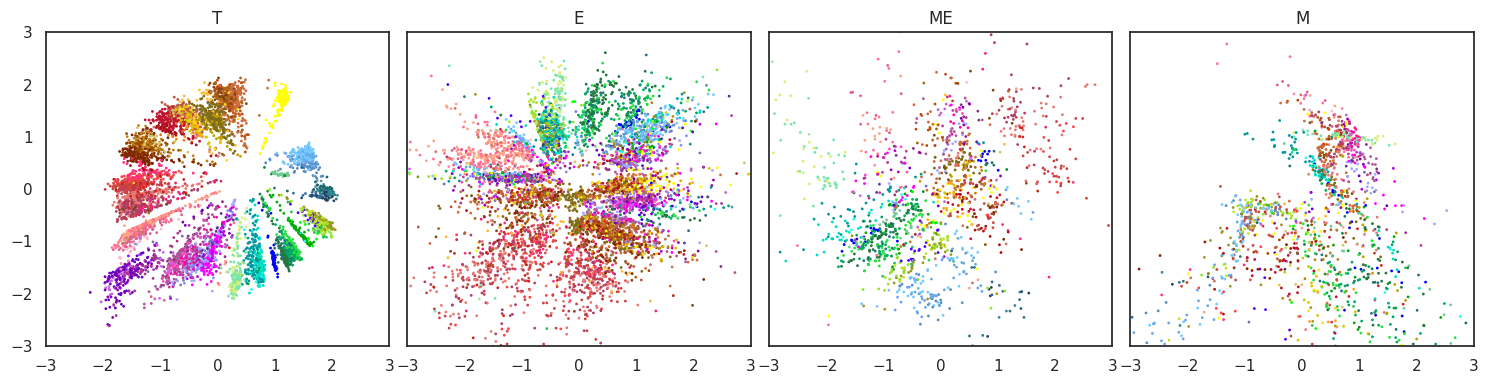

In [8]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/Tonly_Eonly_Monly_8643_103MNPCs_l2_v0"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z(output, xlim=(-3, 3), ylim=(-3, 3))

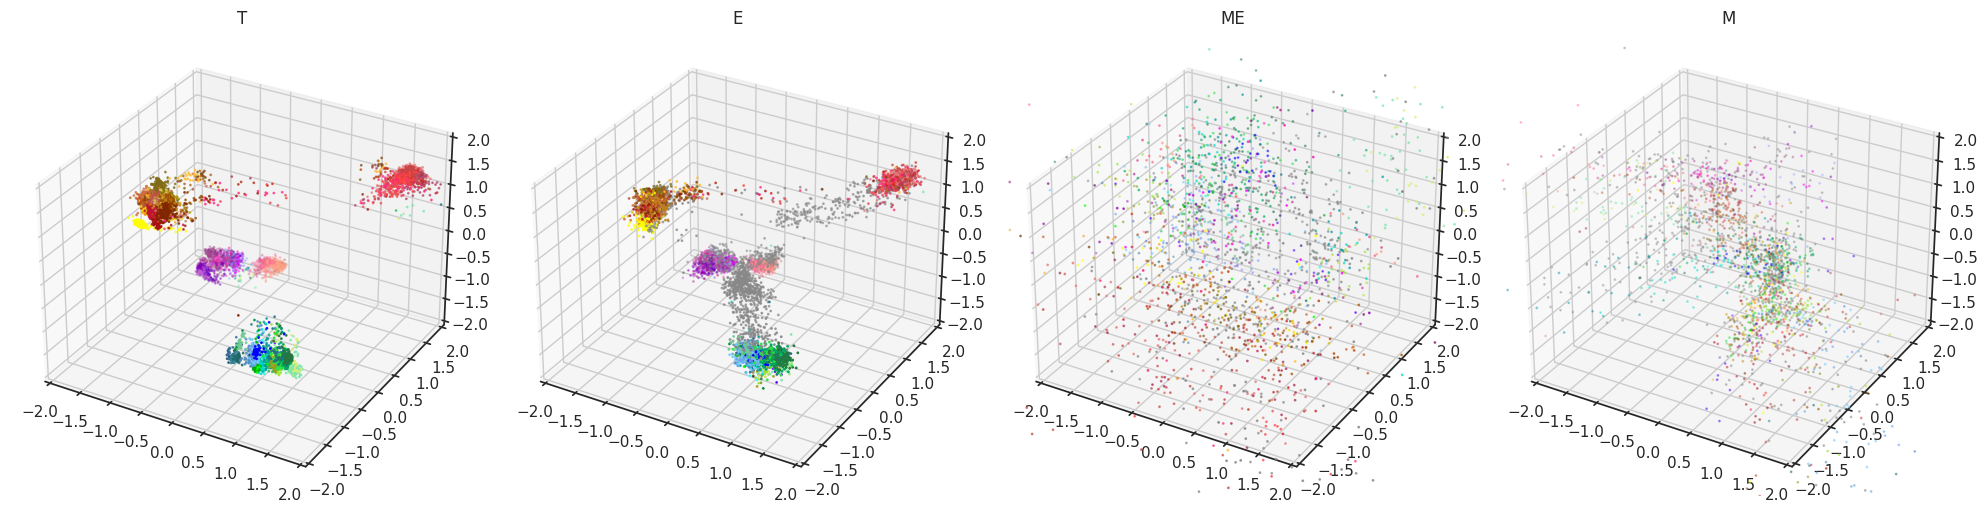

In [7]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/TE_Monly_8643_103MNPCs_l3_v0"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z_3d(output, xlim=(-2, 2), ylim=(-2, 2), zlim=(-2,2))

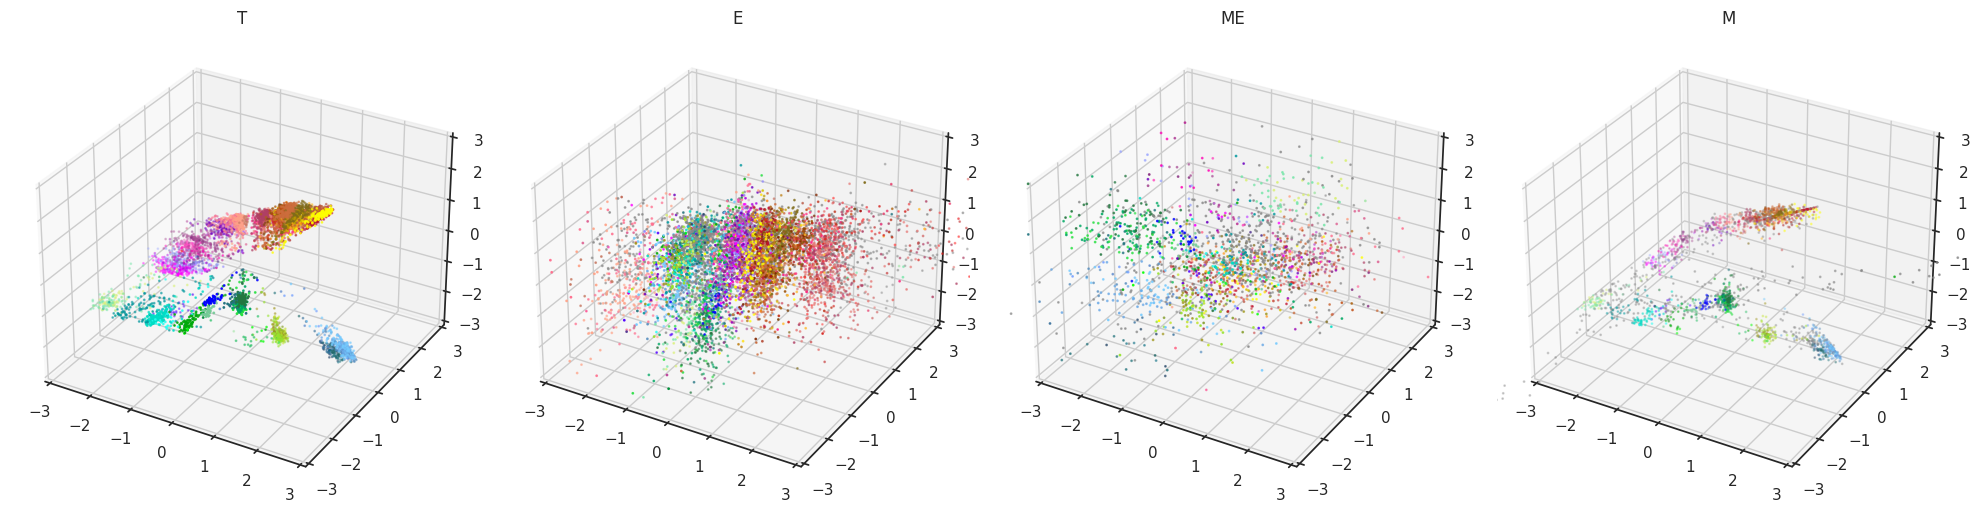

In [8]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/TM_Eonly_8643_103MNPCs_l3_v0"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z_3d(output, xlim=(-3, 3), ylim=(-3, 3), zlim=(-3,3))

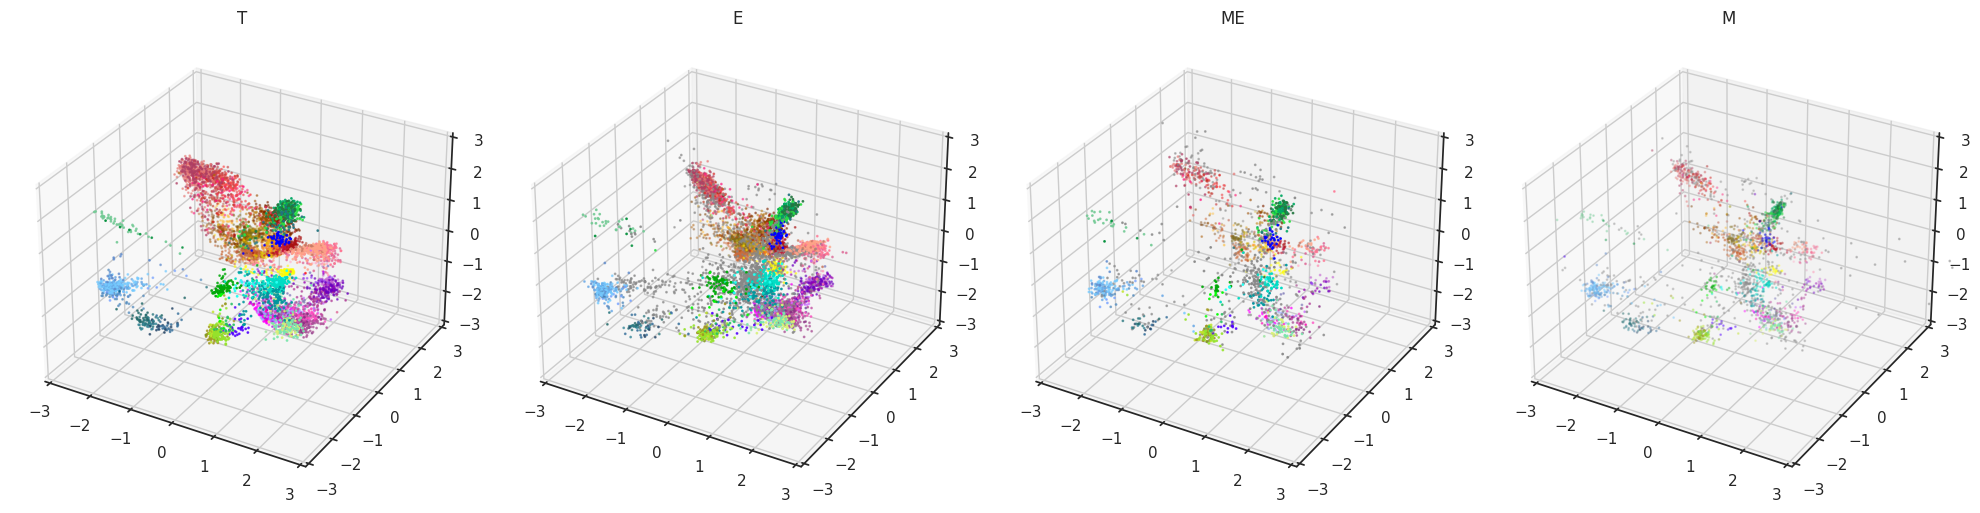

In [7]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/TEM_8643_103MNPCs_l3_v0"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z_3d(output, xlim=(-3, 3), ylim=(-3, 3), zlim=(-3,3))

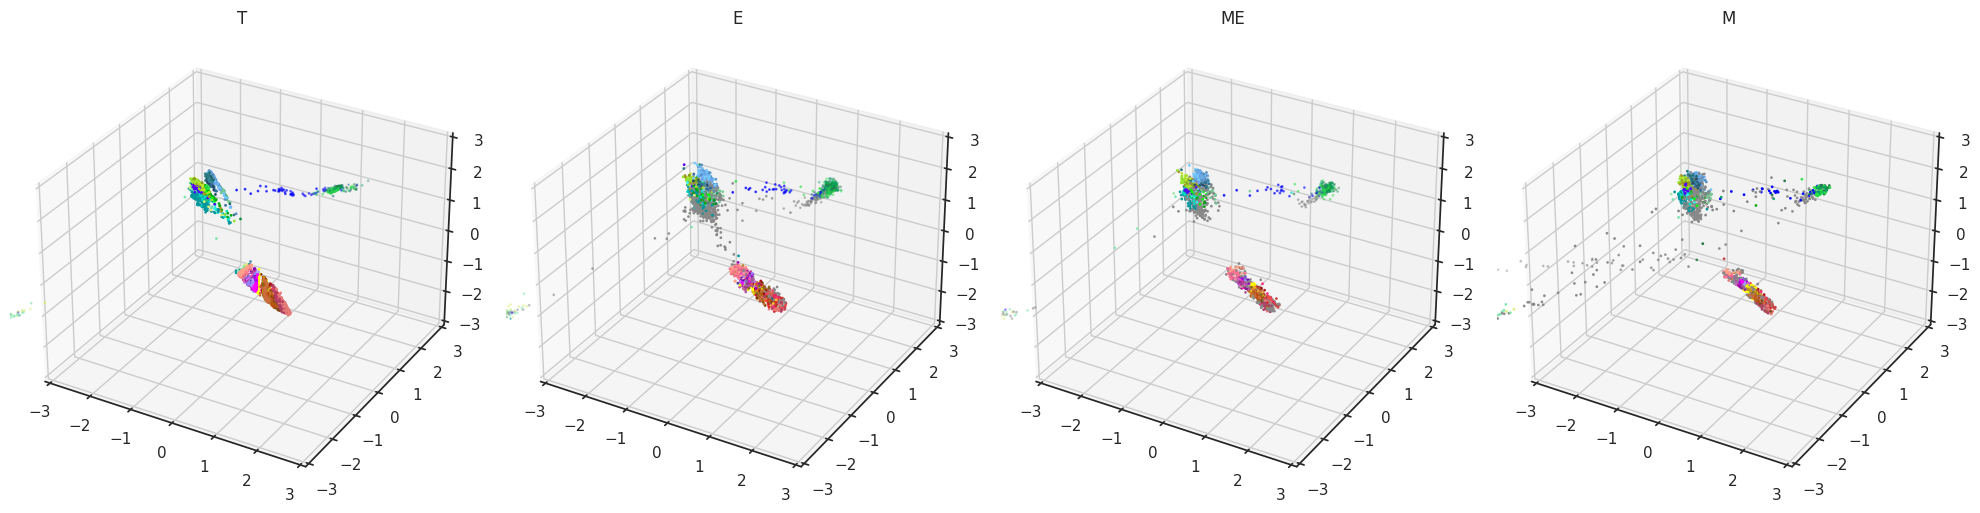

In [9]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/TEM_8643_103MNPCs_l3_v1"
file= "checkpoint_ep_6500_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z_3d(output, xlim=(-3, 3), ylim=(-3, 3), zlim=(-3,3))

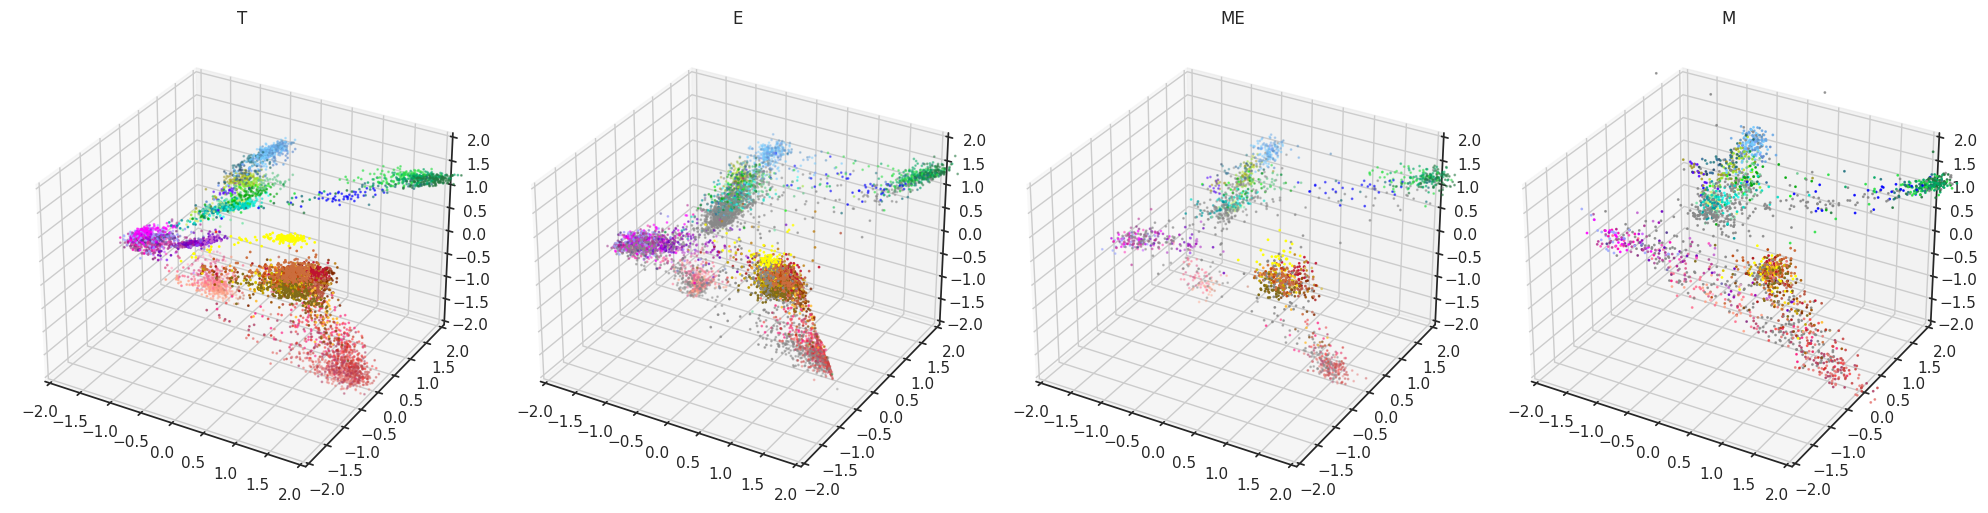

In [5]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/TEM_8643_103MNPCs_26Mfeatures_l3_v0"
file= "checkpoint_ep_500_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z_3d(output, xlim=(-2, 2), ylim=(-2, 2), zlim=(-2,2))

In [6]:
from cplAE_MET.models.classification_functions import run_LDA, run_LogisticRegression

is_t_1d = output['is_t_1d']
is_te_1d = np.logical_and(output['is_t_1d'], output['is_e_1d'])
is_tem_1d = np.logical_and(output['is_m_1d'], is_te_1d)

zt_classification_acc, n_class, clf  = run_LDA(output['zt'][is_t_1d], 
                                               output['cluster_label'][is_t_1d],
                                               test_size=0.1)


print("acc on the zt:", zt_classification_acc, "number of classes:", n_class)
    
ze_classification_acc = clf.score(output['ze'][is_te_1d], output['cluster_label'][is_te_1d]) * 100
    
print("acc on the ze:", ze_classification_acc)

acc on the zt: 47.69230769230769 number of classes: 87
acc on the ze: 28.11752647762214


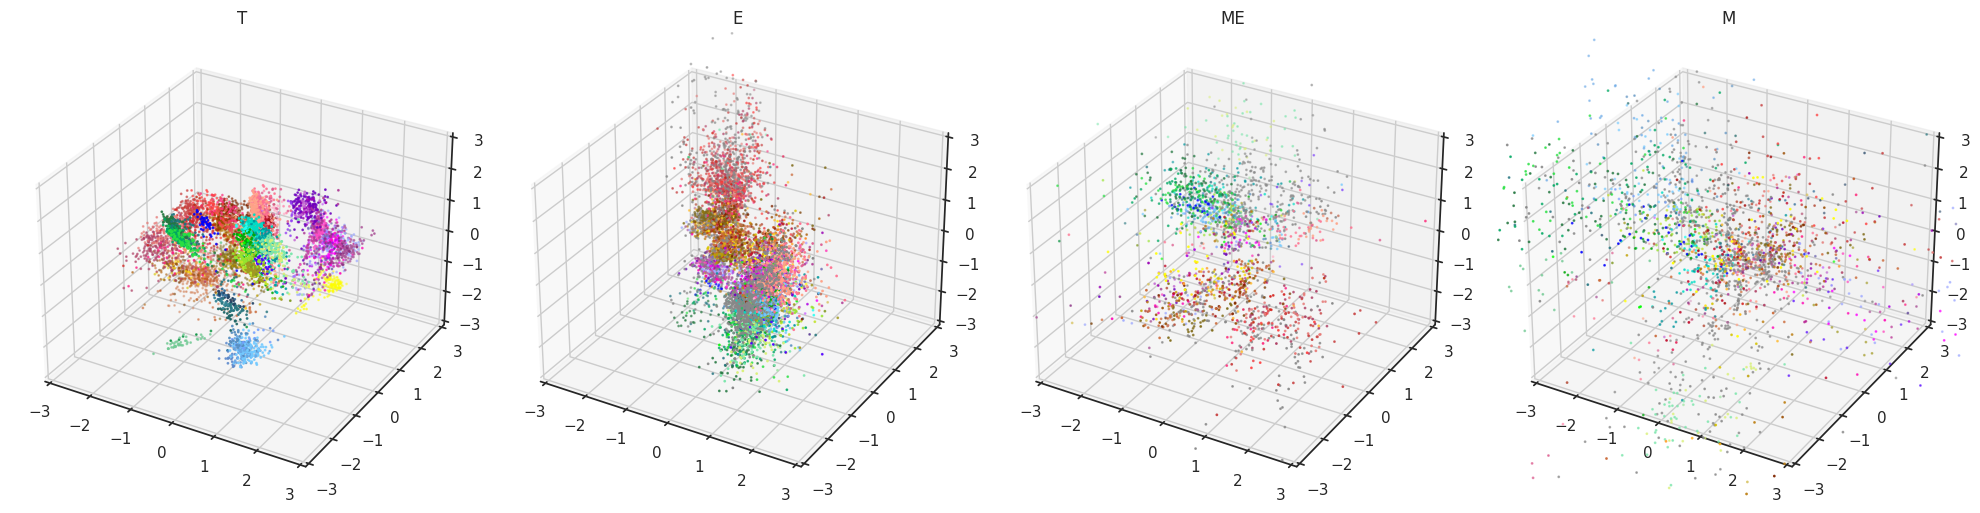

In [80]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/Tonly_Eonly_Monly_8643_103MNPCs_26Mfeatures_l3_v0"
file= "checkpoint_ep_9000_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z_3d(output, xlim=(-3, 3), ylim=(-3, 3), zlim=(-3,3))

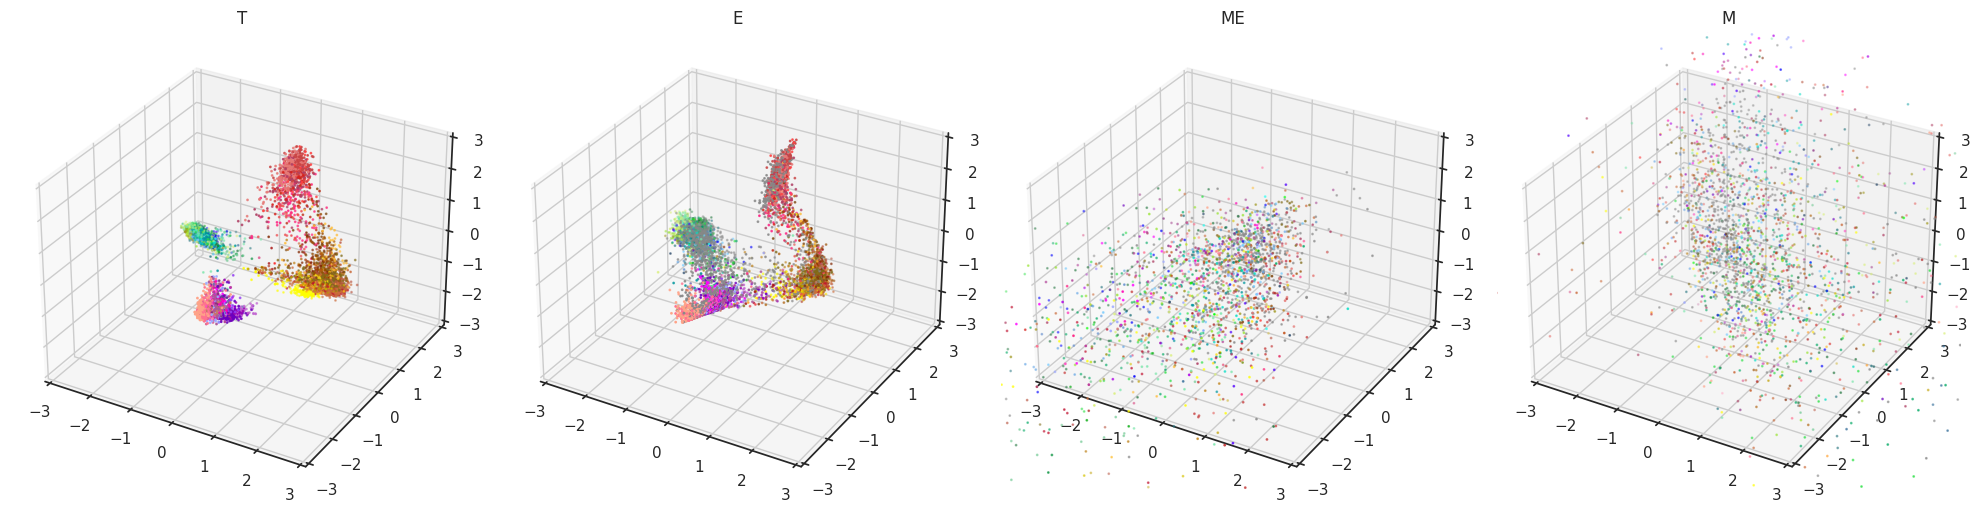

In [84]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/test/"
file= "smbo_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z_3d(output, xlim=(-3, 3), ylim=(-3, 3), zlim=(-3,3))

### Triple modality autoencoder

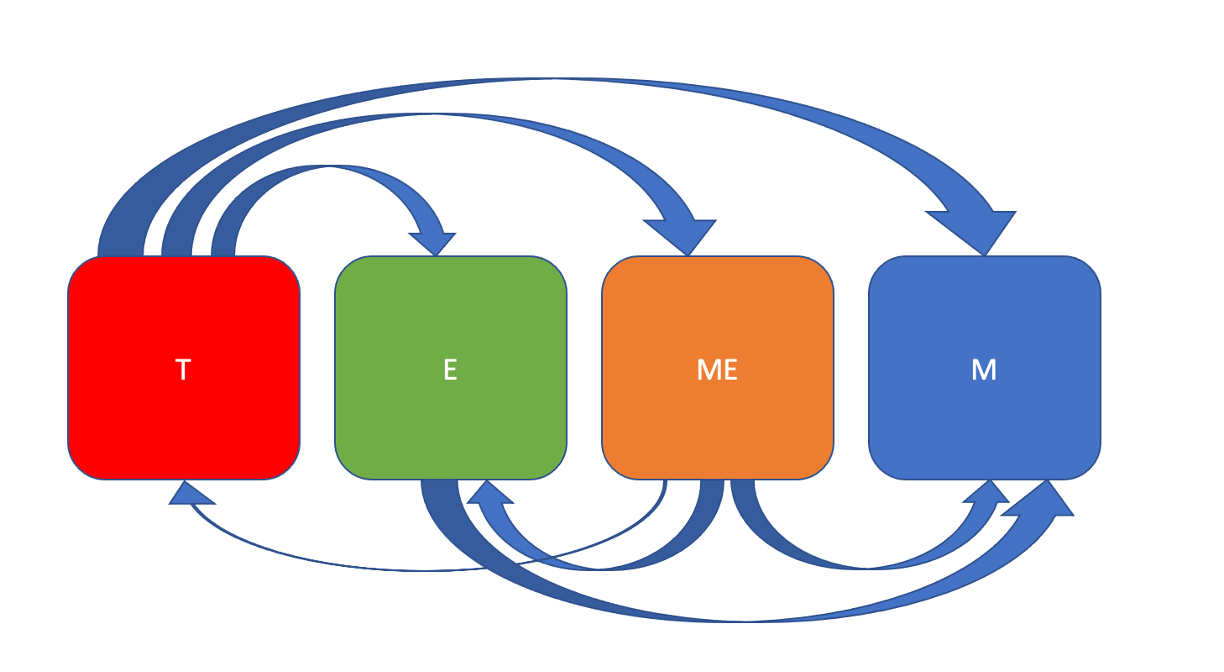

In [15]:
display.Image("/home/fahimehb/Local/data/proc/conections.png", width=500)

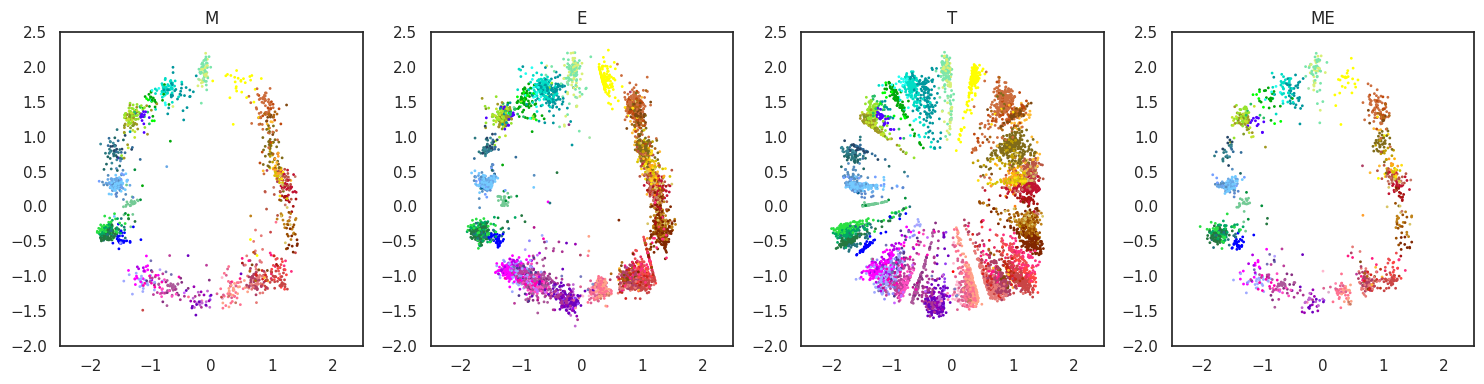

In [23]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_v0"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z(output, xlim=(-2.5, 2.5), ylim=(-2, 2.5))

In [12]:
train_XM = output['XM'][train_ind, ...][output['is_m_1d'][train_ind, ...]]
val_XM = output['XM'][val_ind, ...][output['is_m_1d'][val_ind, ...]]

train_XrM = output['XrM'][train_ind, ...][output['is_m_1d'][train_ind, ...]]
val_XrM = output['XrM'][val_ind, ...][output['is_m_1d'][val_ind, ...]]

train_Xsd = output['Xsd'][train_ind, ...][output['is_m_1d'][train_ind, ...]]
val_Xsd = output['Xsd'][val_ind, ...][output['is_m_1d'][val_ind, ...]]

train_Xrsd = output['Xrsd'][train_ind, ...][output['is_m_1d'][train_ind, ...]]
val_Xrsd = output['Xrsd'][val_ind, ...][output['is_m_1d'][val_ind, ...]]


================================== original arbor density for an Exc cell =====================================


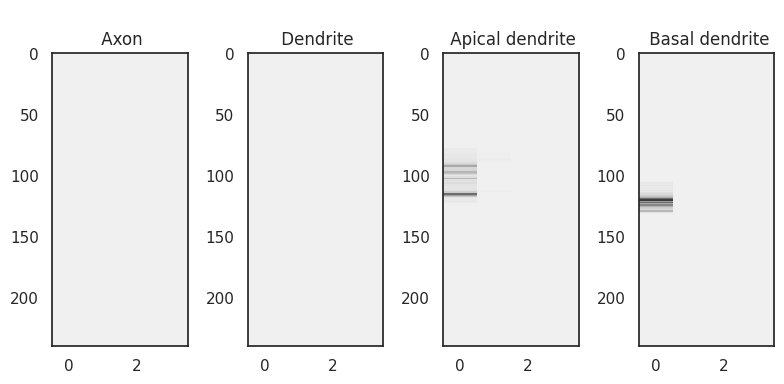

=============================== reconstructed arbor density for an Exc cell ===================================


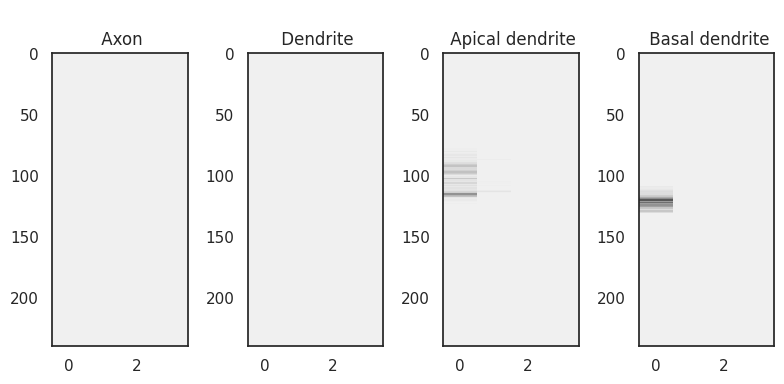

In [13]:
print()
print("================================== original arbor density for an Exc cell =====================================")
plot_m(val_XM[100, 0, ...])
print("=============================== reconstructed arbor density for an Exc cell ===================================")
plot_m(val_XrM[100, 0, ...])


================================== original arbor density for an Inh cell =====================================


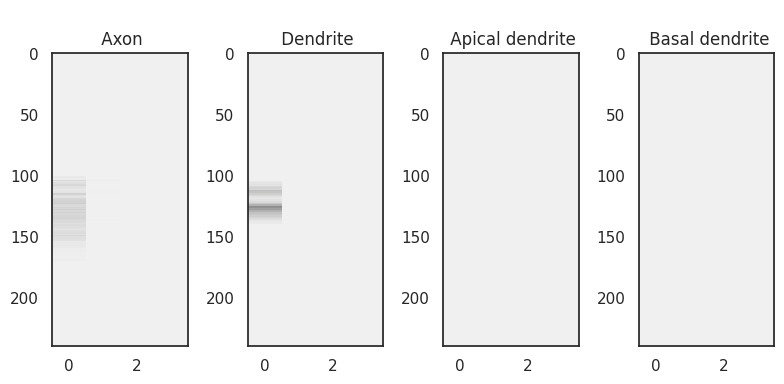

=============================== reconstructed arbor density for an Inh cell ===================================


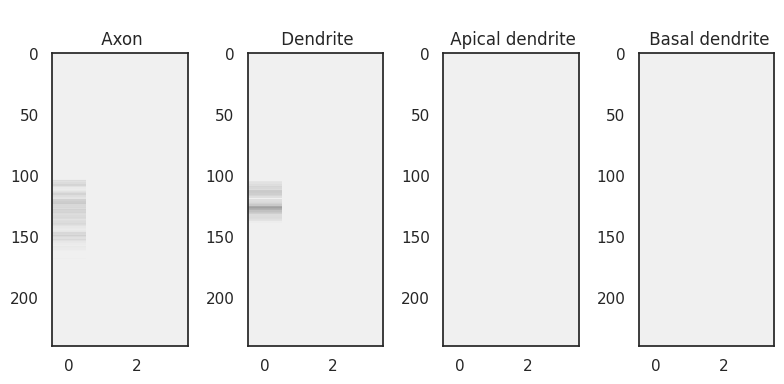

In [14]:
print()
print("================================== original arbor density for an Inh cell =====================================")
plot_m(val_XM[50, 0, ...])
print("=============================== reconstructed arbor density for an Inh cell ===================================")
plot_m(val_XrM[50, 0, ...])

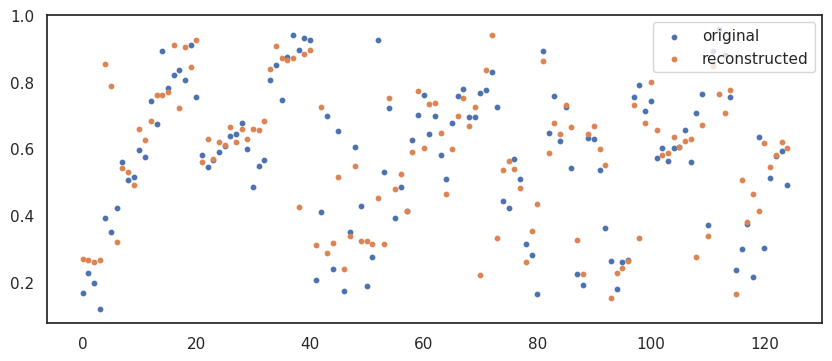

In [19]:
fig = plt.figure(figsize=(10,4))
plt.scatter([i for i in range(len(val_Xsd))], val_Xsd, s=10, label="original")
plt.scatter([i for i in range(len(val_Xsd))], val_Xrsd, s=10, label="reconstructed")
plt.legend(loc="upper right")

### Triple modality autoencoder with augmentation in decoders

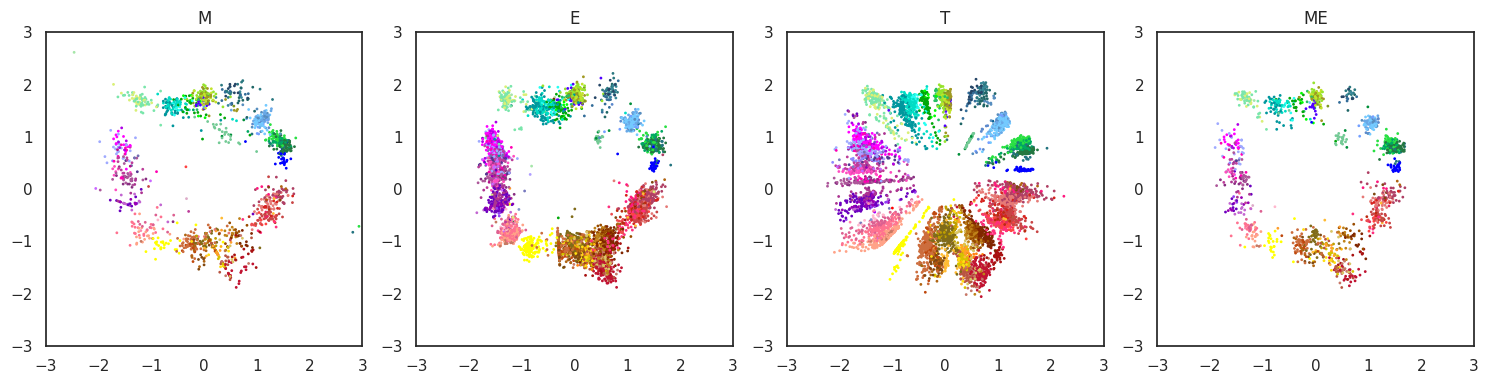

In [13]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_ME_cells_Edata_debugged_Mdata_zeroed_channels_v0"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-3, 3), ylim=(-3, 3))

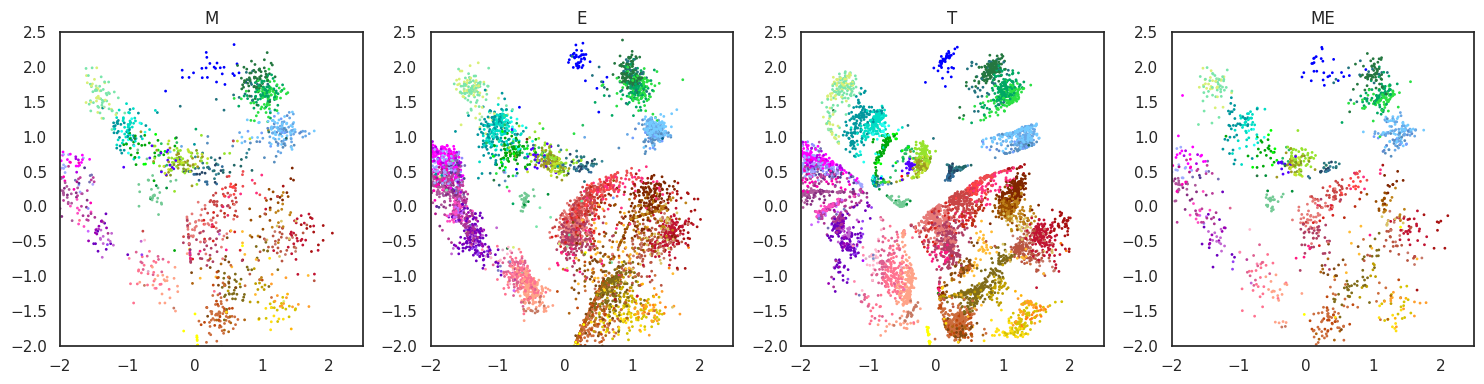

In [14]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_ME_cells_Edata_debugged_Mdata_zeroed_channels_aug_dec_v0"

file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-2, 2.5), ylim=(-2, 2.5))

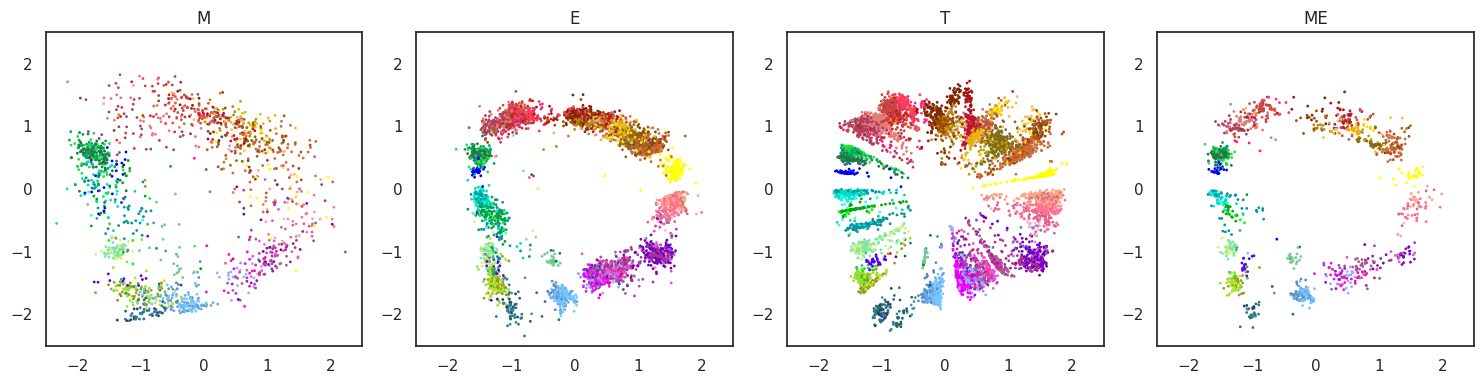

In [11]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connetced_M_data_PCs_new_E_data_v1_no_noise_no_drp_for_M"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))

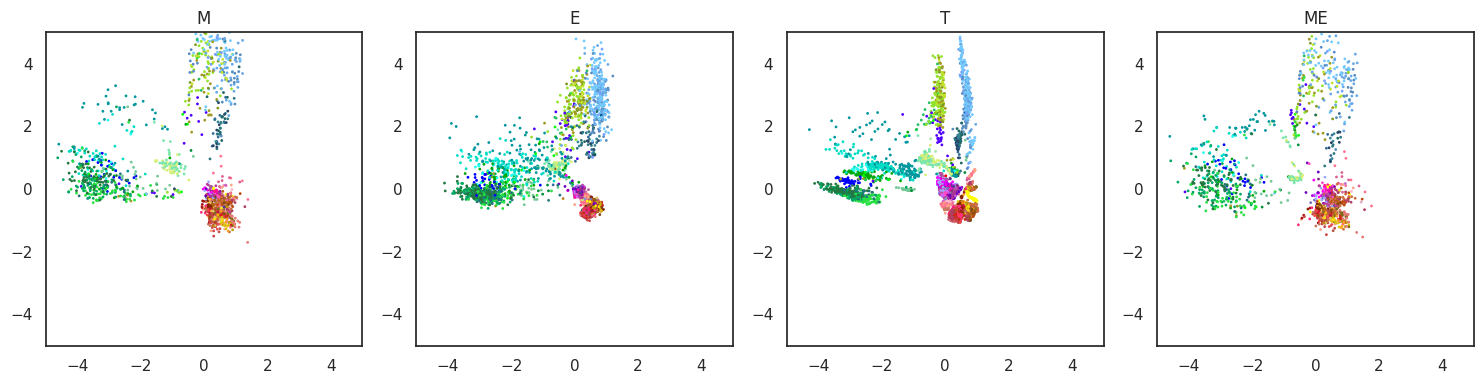

In [24]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_40M_NOTscaled_PCs_83EPCs_no_noise_no_drp"
file= "checkpoint_ep_2500_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-5, 5), ylim=(-5, 5))

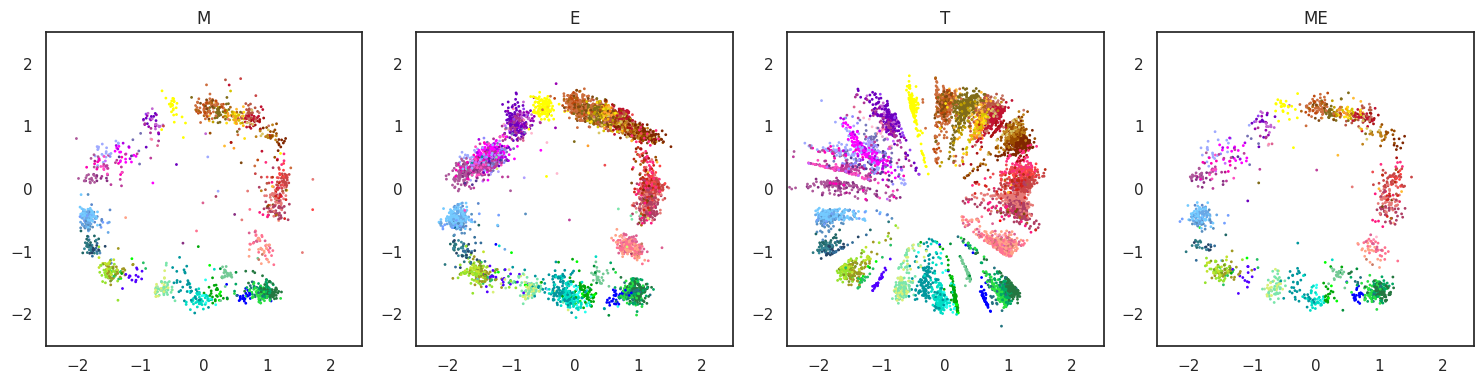

In [5]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_40M_scaled_PCs_83EPCs_no_noise_no_drp"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))

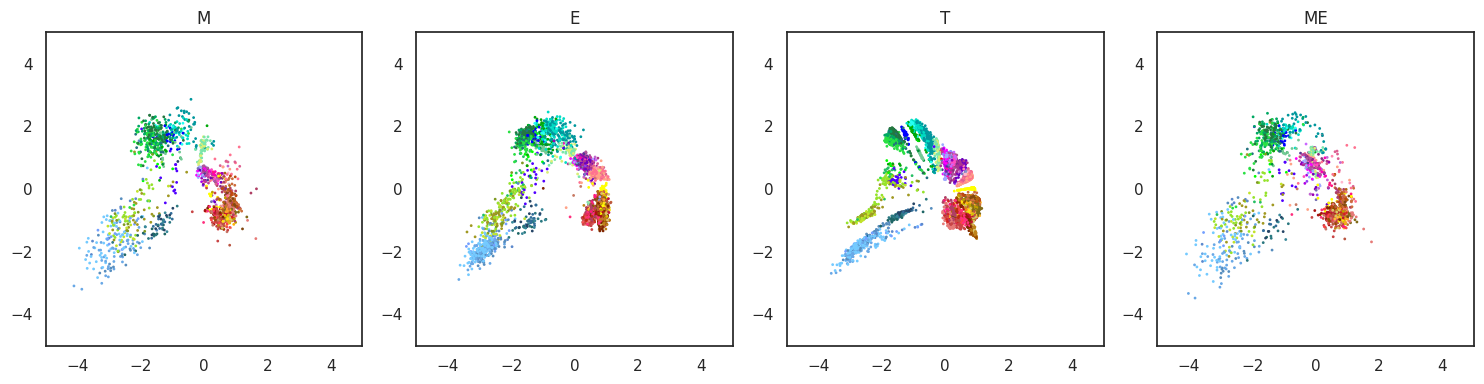

In [11]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_80M_NOTscaled_PCs_83EPCs_no_noise_no_drp"
file= "checkpoint_ep_7000_test.pkl"
#file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-5, 5), ylim=(-5, 5))
# plot_z(output, xlim=(-2, 2.5), ylim=(-3.5, 2.5))

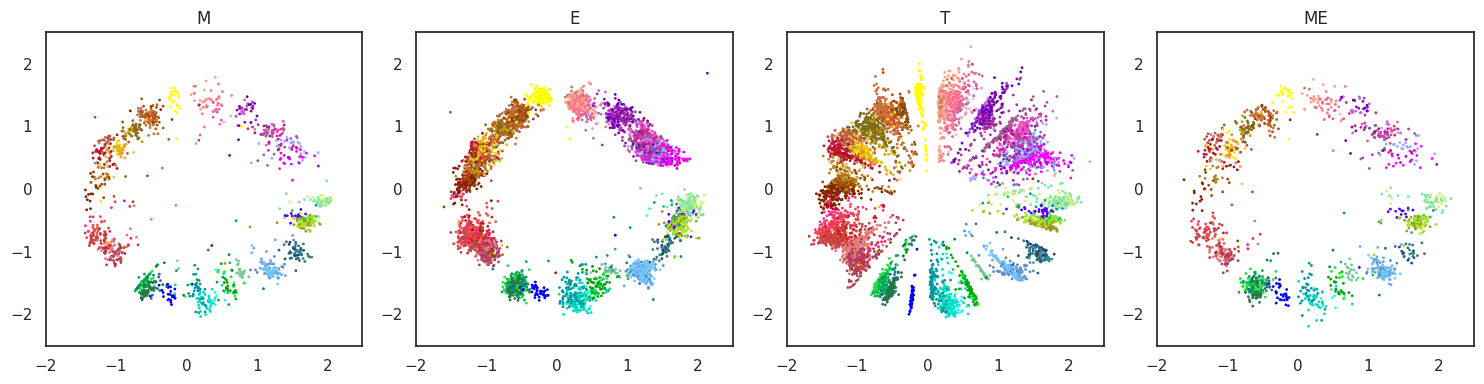

In [4]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_80M_scaled_PCs_83EPCs_no_noise_no_drp"
file= "exit_summary_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-2, 2.5), ylim=(-2.5, 2.5))

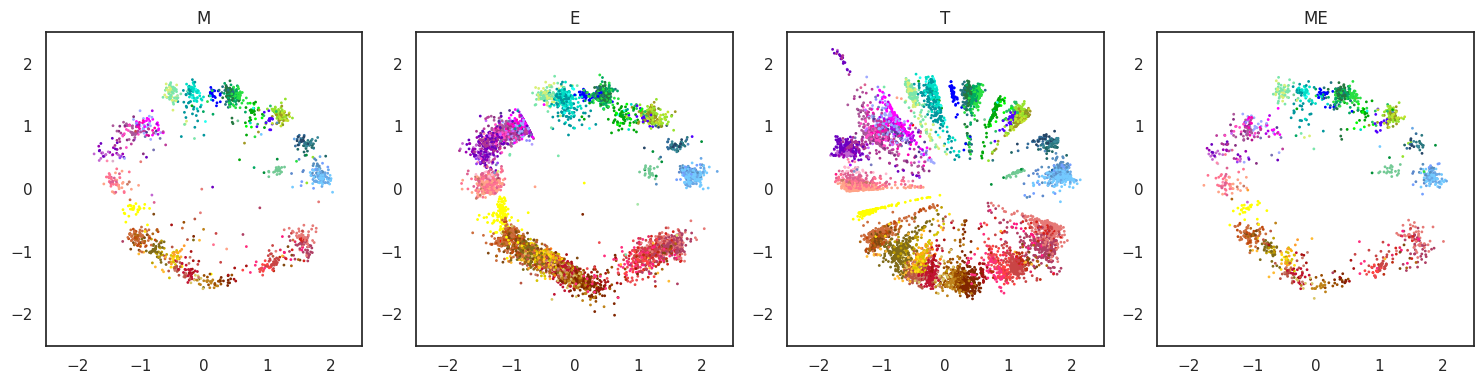

In [5]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_103M_scaled_PCs_83EPCs_no_noise_no_drp"
file= "checkpoint_ep_41000_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))

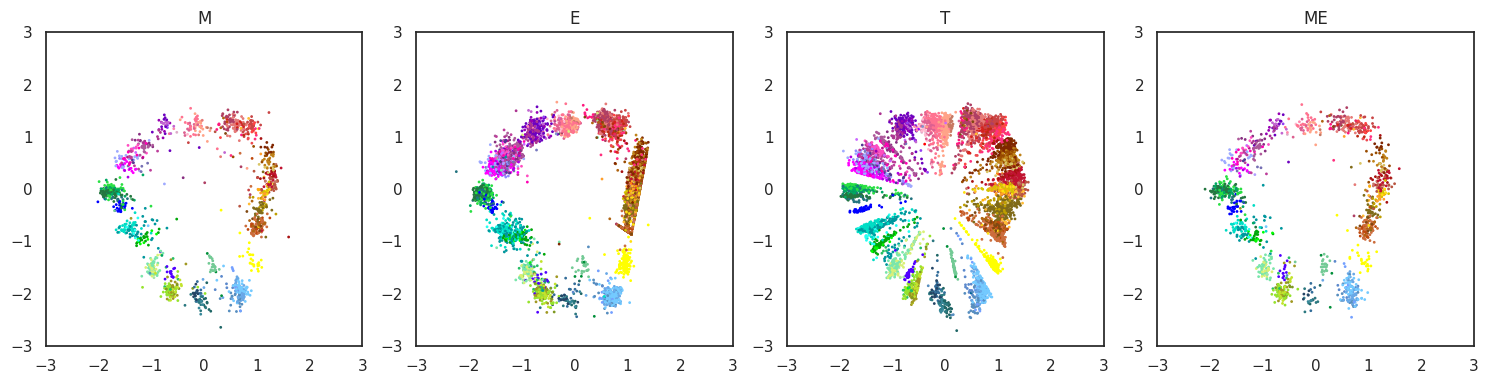

In [7]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_70M_scaled_PCs_83EPCs_no_noise_no_drp"
file= "checkpoint_ep_47000_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-3, 3), ylim=(-3, 3))

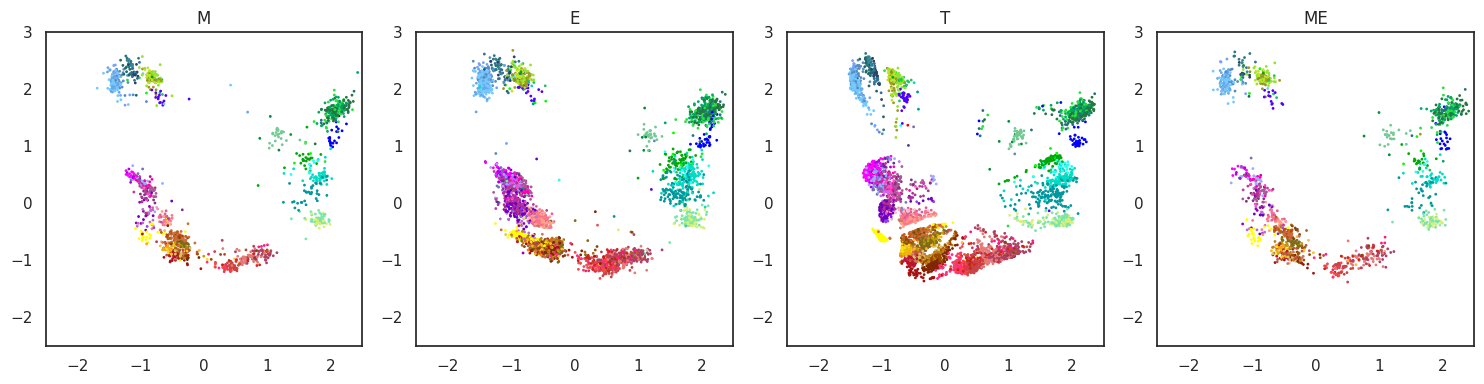

In [6]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_80M_scaled_PCs_83EPCs_no_noise_no_drp_all_Mdatavars_removed"
file= "checkpoint_ep_38000_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-2.5, 2.5), ylim=(-2.5, 3))

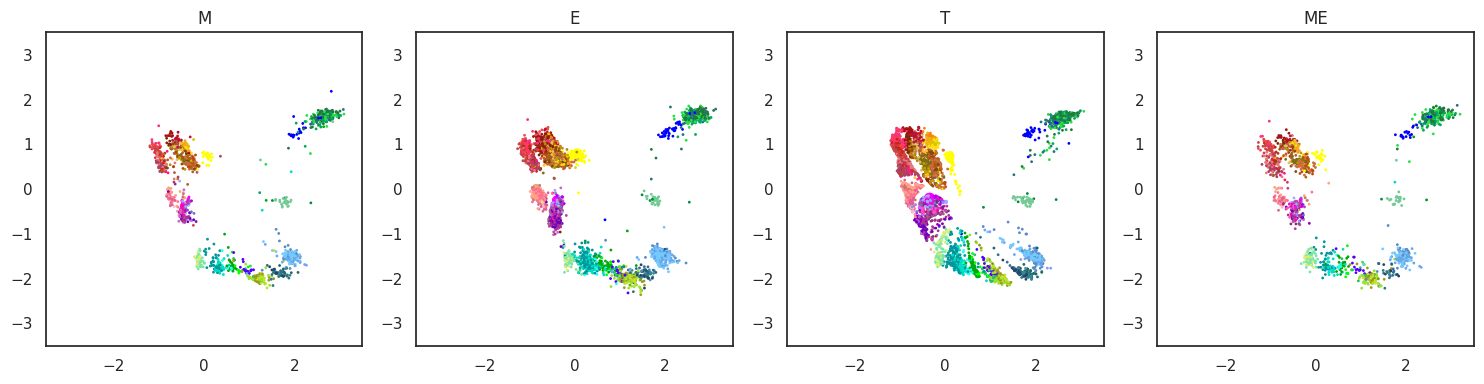

In [9]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_96M_scaled_PCs_83EPCs_no_noise_no_drp_all_Mdatavars_removed"
file= "checkpoint_ep_35000_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-3.5, 3.5), ylim=(-3.5, 3.5))

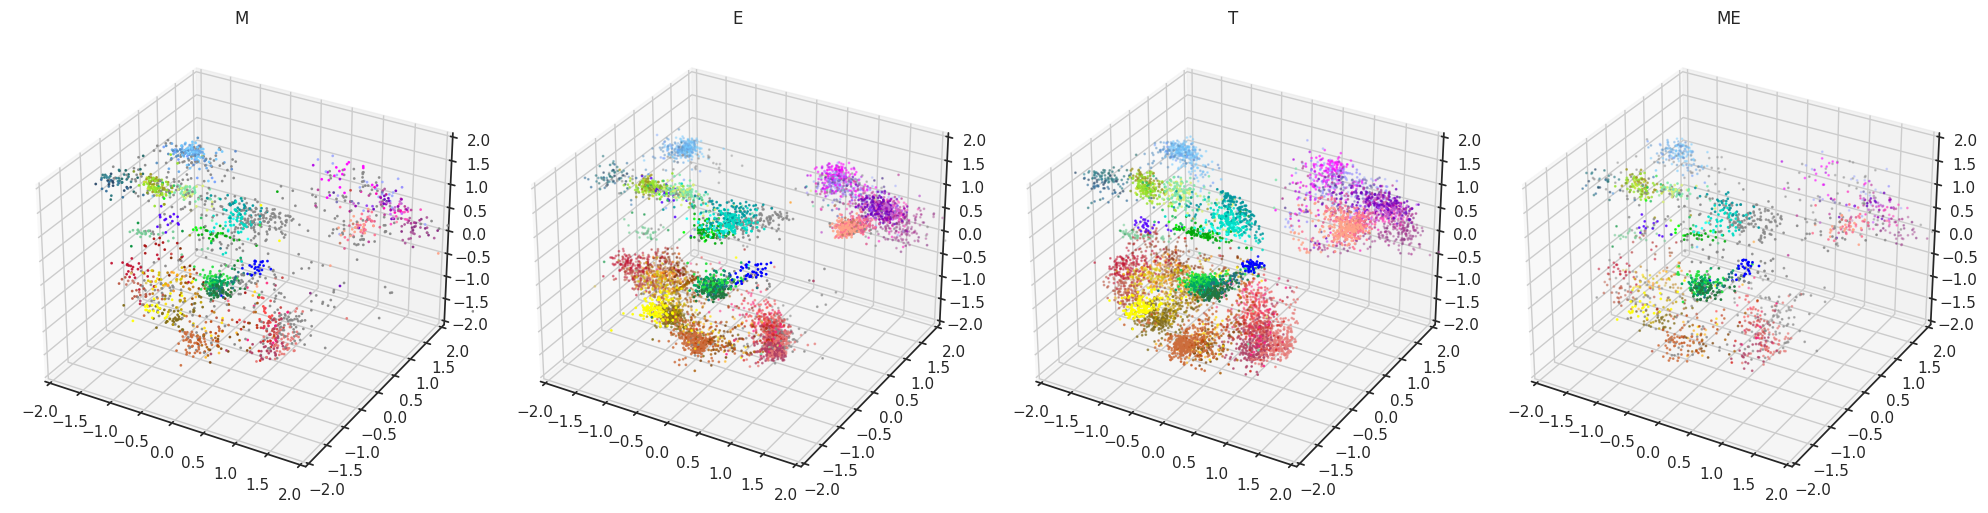

In [5]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_80M_scaled_PCs_83EPCs_no_noise_no_drp_v2"
file= "checkpoint_ep_34500_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z_3d(output, xlim=(-2., 2.), ylim=(-2., 2.), zlim=(-2.,2.))

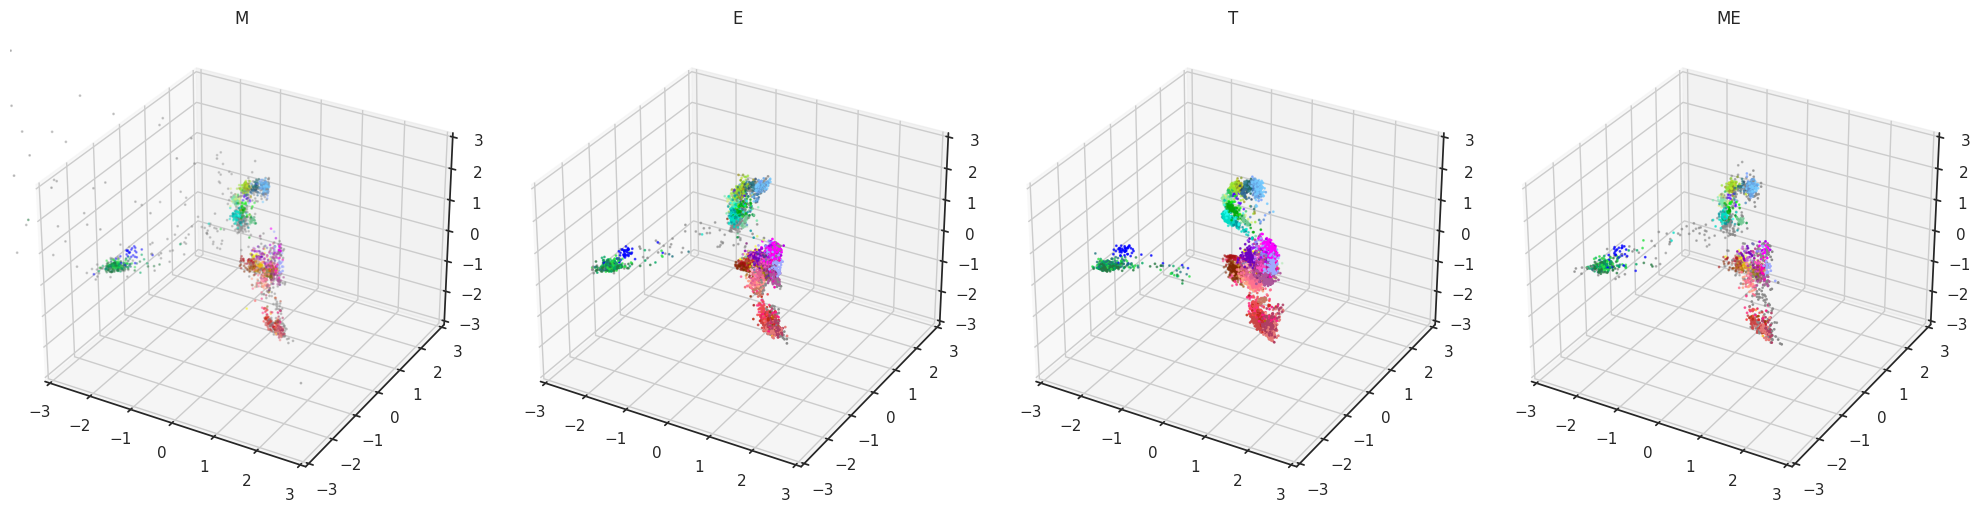

In [3]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_76MscaledPCs_83EPCs"
file= "checkpoint_ep_49000_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z_3d(output, xlim=(-3., 3.), ylim=(-3., 3.), zlim=(-3.,3.))

In [ ]:
    def run_classification(model, model_config, dataloader):
        model.eval()
        for all_data in iter(dataloader):
            _, z_dict, _ = model(all_data) 

        is_t_1d = tonumpy(all_data['is_t_1d'])
        is_e_1d = tonumpy(all_data['is_e_1d'])
        is_m_1d = tonumpy(all_data['is_m_1d'])
        is_te_1d = np.logical_and(is_t_1d, is_e_1d)
        is_tm_1d = np.logical_and(is_t_1d, is_m_1d)
        is_me_1d = np.logical_and(is_m_1d, is_e_1d)
        is_met_1d = np.logical_and(is_t_1d, is_me_1d)
        T_labels = np.array(dat.cluster_label) #TODO these labels should become part of dataloader

        zt = tonumpy(z_dict['zt'])
        ze = tonumpy(z_dict['ze'])
        zm = tonumpy(z_dict['zm'])
        zme_paired = tonumpy(z_dict['zme_paired'])
        
        zt_classification_acc, n_class, clf = run_LDA(zt[is_t_1d], 
                                                T_labels[is_t_1d],
                                                train_test_ids={'train':[i for i in train_ind if is_t_1d[i]], 
                                                                'val':[i for i in val_ind if is_t_1d[i]]})

        # print("acc on the zt:", zt_classification_acc, "number of classes:", n_class)
        
        te_cpl_score = clf.score(ze[is_te_1d], T_labels[is_te_1d]) * 100
        tm_cpl_score = clf.score(zm[is_tm_1d], T_labels[is_tm_1d]) * 100
        met_cpl_score = clf.score(zme_paired[is_met_1d], T_labels[is_met_1d]) * 100

        # print("acc on the ze:", te_cpl_score)
        # print("acc on the zm:", tm_cpl_score)
        # print("acc on the zme_paired:", met_cpl_score)

        model_score = np.mean([model_config['TE']['lambda_TE'] * te_cpl_score,
                      model_config['TM']['lambda_TM'] * tm_cpl_score,
                      model_config['ME_T']['lambda_ME_T'] * met_cpl_score])

        return model_score